# Classification Prediction with Imbalanced Target

# Mary Donovan Martello

## The goal of this project was to design predictive binary classification models to predict whether credit card account holders will default on their payments in the next month. This notebook includes exploratory data analysis and data preparation for the project.

## Part 1: Exploratory Data Analysis, Data Preparation and Feature Selection

In [2]:
# import libraries for data preparation and exploration phase
import pandas as pd
import numpy as np
# importing regex module (search strings) RegEx can be used to check if a string contains the specified search pattern
import re
#from pandas_profiling import ProfileReport

import yellowbrick
from yellowbrick.features import Rank2D
import matplotlib.pyplot as plt
import seaborn as sn

# import libraries for statistical exploratory analysis
from collections import Counter
import random
import scipy.stats
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

# scaling and feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier

# PCA
from sklearn.decomposition import PCA

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')


In [3]:
# import data
df = pd.read_csv('UCI_Credit_Card.csv')

**The dataset used for this project includes actual credit card records at points in time in the past.  Each record in the dataset also includes a label of whether the account holder defaulted the next month (default = 0) or did not default the next month (default = 1).  Each record also includes demographic data of the account holder (age, gender, marital status and education), as well as the account holder’s credit limit, and multiple monthly values of how long the payments are overdue, the debt outstanding, and the amounts of previous payments.**

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Cleaning

## Fix Pay Columns Value Discrepancy

**The variables named "PAY_0" through "PAY_6" are the repayment status for six consecutive months.  A value of 1 means the account is one month late, a value of 2 means the account is two months late, etc.  In reviewing histograms of the six "PAY" variables, a discrepancy in the values for these columns were identified.  The histograms show that of the six different months of payment information only one of those months show counts for payment status = 1 (payment is 1 month late) but the counts for all six months show over 2,000 counts for payment status = 2 (payment is 2 months late).  This seems like a discrepancy because a payment cannot be two months late in August, for example, but not be one month late in July.  Therefore, I assigned a value representing one month late in any record in which the next month’s value represented that the payment was two months late.  The below code is for this task.**

Assign a value representing one month late in any record in which the next month’s value represented that the payment was two months late.

The next five cells have code blocks for 5 different variables.  I commented out four each time and progressed through the five cells five times. 

In [3]:
# subset of PAY_ columns
# pay0 = df[df['PAY_0'] == 2]
# other = df[df['PAY_0'] != 2]
# print(pay0.shape)
# print(other.shape)

# pay2 = df[df['PAY_2'] == 2]
# other = df[df['PAY_2'] != 2]
# print(pay2.shape)
# print(other.shape)

# pay3 = df[df['PAY_3'] == 2]
# other = df[df['PAY_3'] != 2]
# print(pay3.shape)
# print(other.shape)

# pay4 = df[df['PAY_4'] == 2]
# other = df[df['PAY_4'] != 2]
# print(pay4.shape)
# print(other.shape)

pay5 = df[df['PAY_5'] == 2]
other = df[df['PAY_5'] != 2]
print(pay5.shape)
print(other.shape)




(2626, 25)
(27374, 25)


In [61]:
#pay0.index
#pay2.index
#pay3.index
#pay4.index
pay5.index

Int64Index([   62,    71,    90,   104,   112,   120,   160,   187,   327,
              329,
            ...
            29338, 29398, 29557, 29700, 29806, 29845, 29853, 29941, 29954,
            29967],
           dtype='int64', length=1778)

In [62]:
#pay0.at[0:29994,'PAY_2'] = 1
#pay2.at[1:29991,'PAY_3'] = 1
#pay3.at[62:29997,'PAY_4'] = 1
#pay4.at[50:29947,'PAY_5'] = 1
pay5.at[62:29967,'PAY_6'] = 1

In [63]:
#pay0['PAY_2'].value_counts()
#pay2['PAY_3'].value_counts()
#pay3['PAY_4'].value_counts()
#pay4['PAY_5'].value_counts()
pay5['PAY_6'].value_counts()

1    1778
Name: PAY_6, dtype: int64

In [64]:
# concatenate the two dfs again
#df = pd.concat([pay0, other], axis=0)
#df = pd.concat([pay2, other], axis=0)
#df = pd.concat([pay3, other], axis=0)
#df = pd.concat([pay4, other], axis=0)
df = pd.concat([pay5, other], axis=0)

In [68]:
# export the revised df to a csv file
df.to_csv('UCI_Credit_CardRev.csv', index = False)

In [2]:
# use for importing data without repeating the previous section of code for fixing the variable discrepancies.
# import data
#df = pd.read_csv('UCI_Credit_CardRev.csv')

### Data Cleaning continued.

In [70]:
# print the column names
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [4]:
# rename difficult column names

df.rename(columns={'PAY_0': 'PAY_1', 'default.payment.next.month': 'default'}, inplace=True)
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,63,50000.0,1,1,2,29,2,1,2,1,2,1,24987.0,24300.0,26591.0,25865.0,27667.0,28264.0,0.0,2700.0,0.0,2225.0,1200.0,0.0,1
1,72,320000.0,1,2,2,29,2,1,2,1,2,1,58267.0,59246.0,60184.0,58622.0,62307.0,63526.0,2500.0,2500.0,0.0,4800.0,2400.0,1600.0,1
2,91,200000.0,1,1,1,53,2,1,2,1,2,1,138180.0,140774.0,142460.0,144098.0,147124.0,149531.0,6300.0,5500.0,5500.0,5500.0,5000.0,5000.0,1
3,105,60000.0,2,2,2,26,2,1,2,1,2,1,56685.0,55208.0,59175.0,60218.0,55447.0,55305.0,0.0,5000.0,2511.0,6.0,3000.0,3000.0,0
4,113,280000.0,1,2,1,41,2,1,2,1,2,1,135673.0,138532.0,134813.0,144401.0,152174.0,149415.0,6500.0,0.0,14254.0,14850.0,0.0,5000.0,0


In [10]:
# rearrange column order
df = df[['ID', 'default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

In [11]:
df.head()

,ID,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,63,1,1,1,2,29,50000.0,2,1,2,1,2,1,24987.0,24300.0,26591.0,25865.0,27667.0,28264.0,0.0,2700.0,0.0,2225.0,1200.0,0.0
1,72,1,1,2,2,29,320000.0,2,1,2,1,2,1,58267.0,59246.0,60184.0,58622.0,62307.0,63526.0,2500.0,2500.0,0.0,4800.0,2400.0,1600.0
2,91,1,1,1,1,53,200000.0,2,1,2,1,2,1,138180.0,140774.0,142460.0,144098.0,147124.0,149531.0,6300.0,5500.0,5500.0,5500.0,5000.0,5000.0
3,105,0,2,2,2,26,60000.0,2,1,2,1,2,1,56685.0,55208.0,59175.0,60218.0,55447.0,55305.0,0.0,5000.0,2511.0,6.0,3000.0,3000.0
4,113,0,1,2,1,41,280000.0,2,1,2,1,2,1,135673.0,138532.0,134813.0,144401.0,152174.0,149415.0,6500.0,0.0,14254.0,14850.0,0.0,5000.0


In [74]:
# check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_1      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [75]:
df.shape

(30000, 25)

In [76]:
# find features with too many nonunique values
distinctList = []
for i in df.columns:
    count = df[i].nunique()
    distinctList.append(count)
    
print(distinctList)

[30000, 81, 2, 7, 4, 56, 11, 11, 11, 11, 11, 11, 22723, 22346, 22026, 21548, 21010, 20604, 7943, 7899, 7518, 6937, 6897, 6939, 2]


In [6]:
# removing ID column as it is just numbering the rows 1 - 30,000
df.drop(columns =['ID'], inplace = True) 
df.shape


(30000, 24)

**Each record in the dataset includes a label of whether the account holder defaulted the next month (default = 0) or did not default the next month (default = 1).  Create separate subsets of the dataset so that one subset only has records that did not have defaults and another subset that only has records that did have defaults.  Use these separate subsets for EDA.** 

In [100]:
# subset for default is 1
rowsYesDefault = df['default'] == 1
defaultY = df.loc[rowsYesDefault, ]
defaultY.shape

(6636, 25)

In [101]:
# subset for default is 0
rowsNoDefault = df['default'] == 0
defaultN = df.loc[rowsNoDefault, ]
defaultN.shape

(23364, 25)

# Exploratory Data Analysis

## Visuals

### Histograms

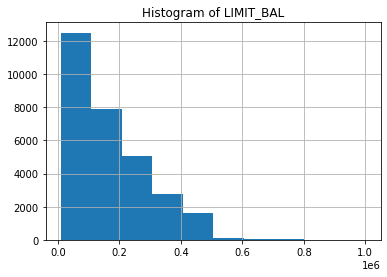

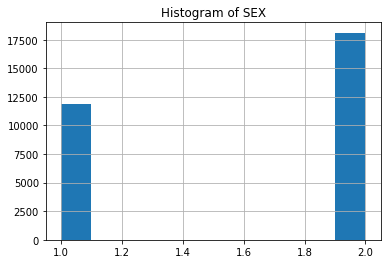

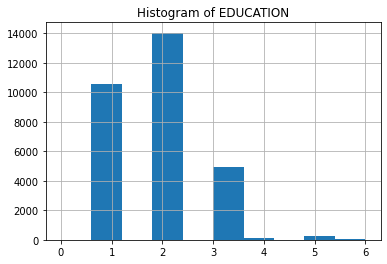

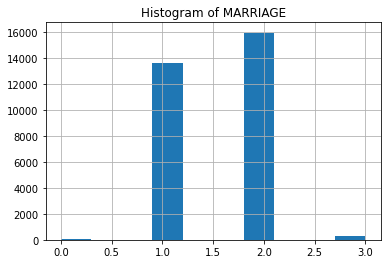

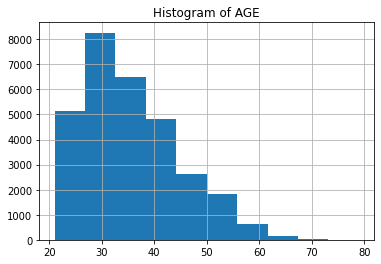

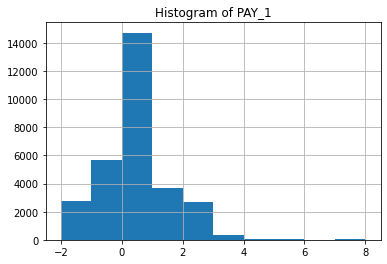

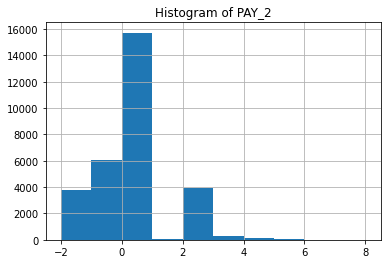

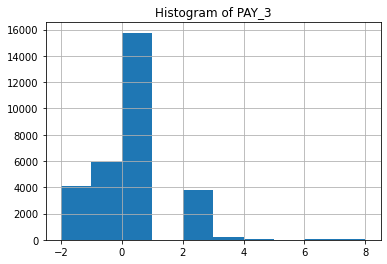

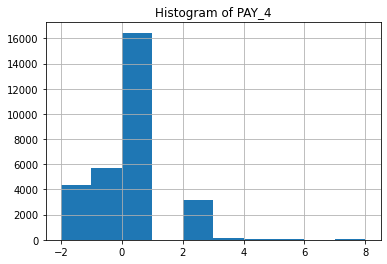

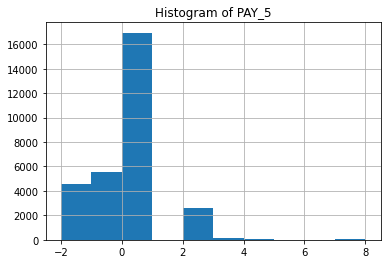

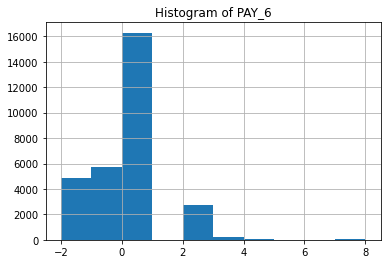

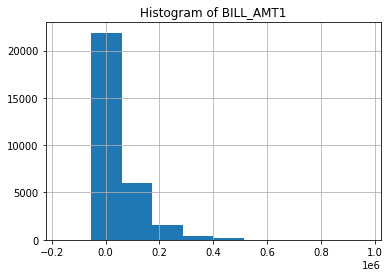

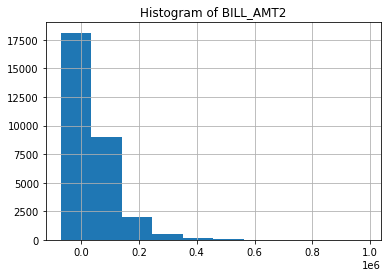

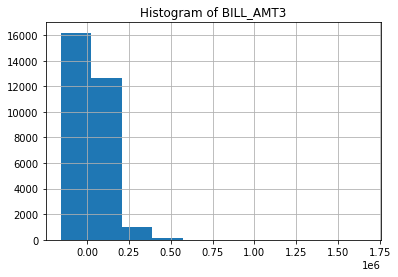

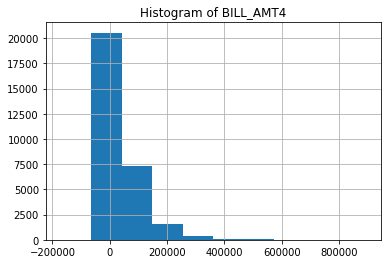

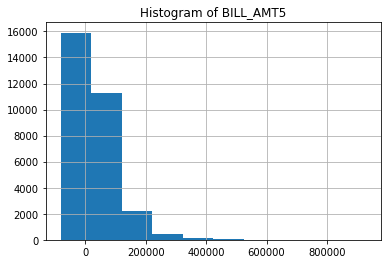

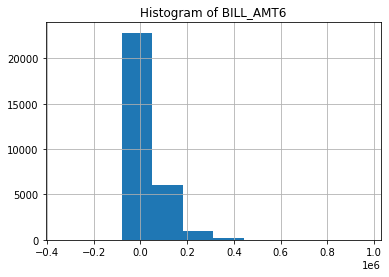

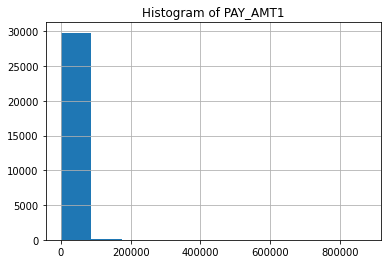

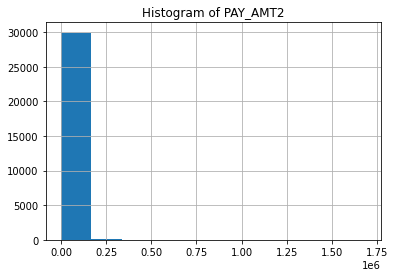

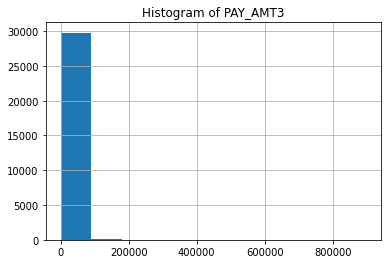

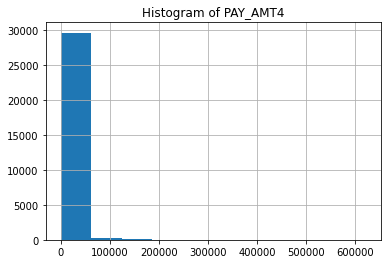

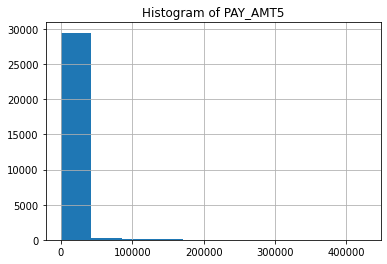

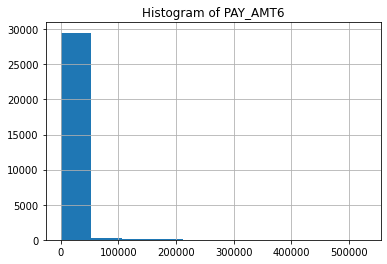

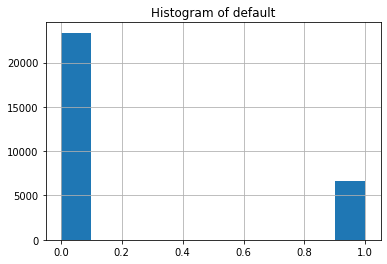

In [14]:
# Plot the histograms of all the variables in the DataFrame.  Plot them all at once using a for loop.  Add unique title.
import matplotlib.pyplot as plt
for i in df:
    df[i].hist()
    plt.title('Histogram of ' + i)
    plt.show()

### Distribution plots comparing default subset with non-default subset.


**Key finding below is that the monthly repayment status distributions showed distinctions between the default records and the non-default records.  The distributions show that the subset of default records have higher counts in those variables that represent that the account holder was late on repaying the account balance than the subset of non-default records.  In fact, even though there are 3.5 times as many non-default records as default records, the default subset has higher counts than the non-default subset in some instances.**

The distributions of the credit limit variables show that the default records have a greater proportion of lower credit limit accounts than the default subset.

Text(0.5, 6.799999999999933, 'Credit Limit Balance')

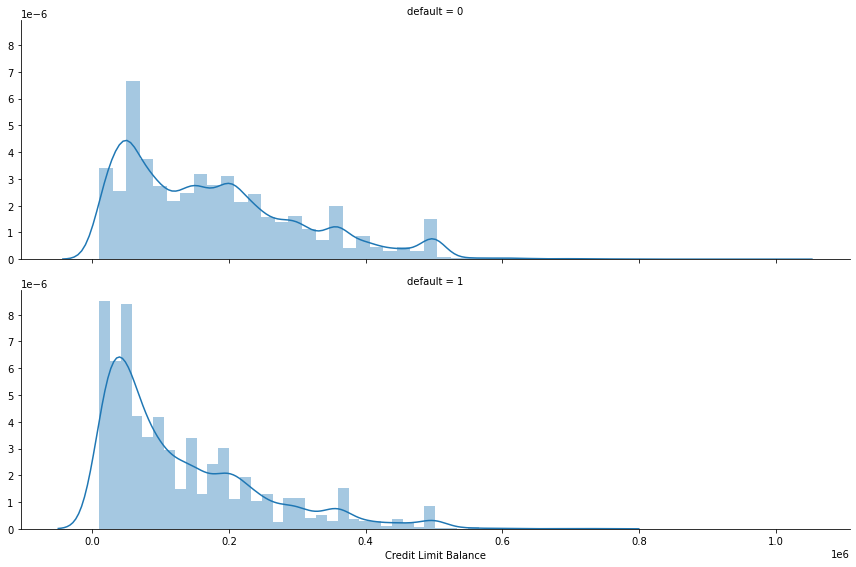

In [16]:
# distribution plots comparing default subset with non-default subset:  credit limit balance

cl = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
cl.map(sn.distplot, "LIMIT_BAL")
plt.xlabel("Credit Limit Balance")


Text(0.5, 6.79999999999999, 'Credit Limit Balance')

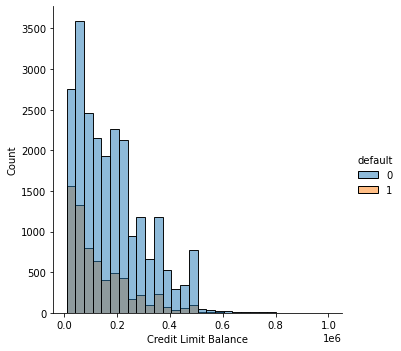

In [43]:
# comparing default subset with non-default subsets: credit limit balance
sn.displot(df, x="LIMIT_BAL", hue="default", bins=30)
plt.xlabel("Credit Limit Balance")

### Demographic differences in the account holders are not distinctive in default cases versus non-default cases.

Text(0.5, 6.799999999999933, 'Gender')

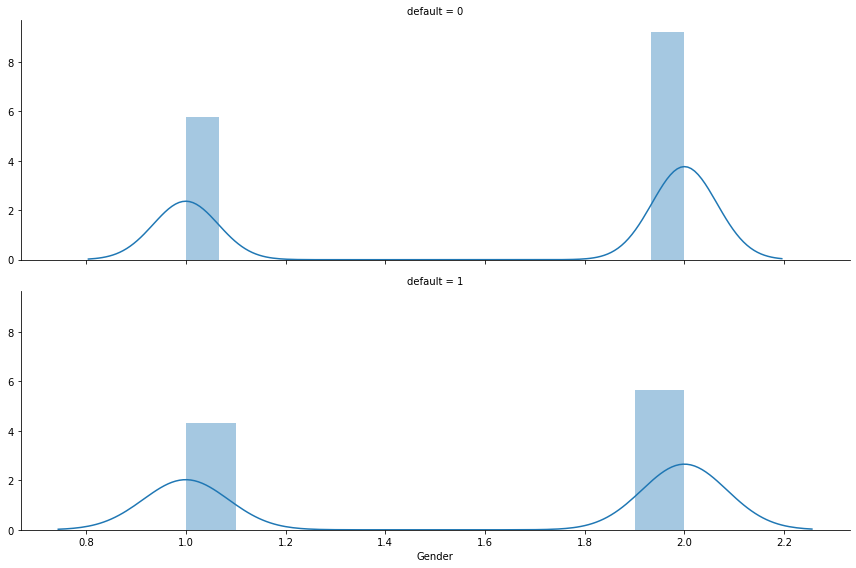

In [17]:
# distribution plots comparing default subset with non-default subsets:  SEX
sex = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
sex.map(sn.distplot, 'SEX')
plt.xlabel("Gender")

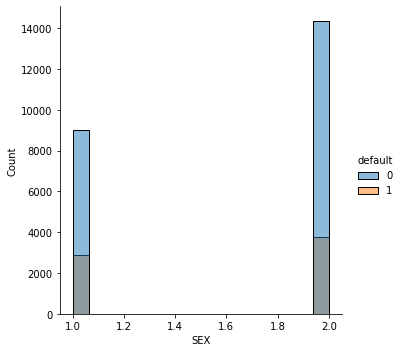

In [45]:
# comparing default subset with non-default subsets: Sex
sn.displot(df, x="SEX", hue="default")

Text(0.5, 6.799999999999933, 'Education')

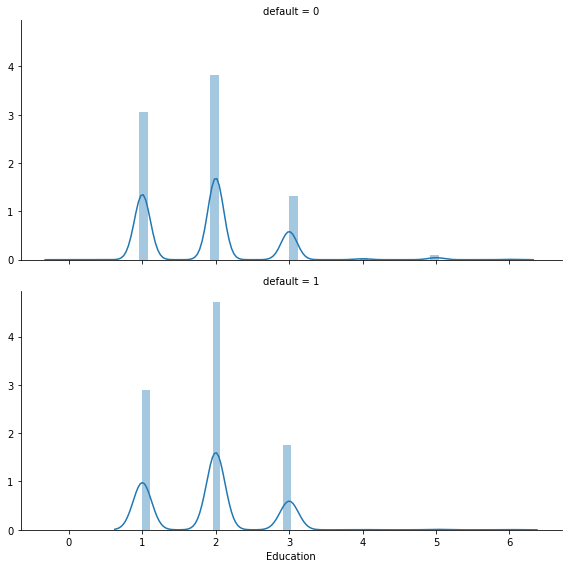

In [18]:
# distribution plots comparing default subset with non-default subsets: Education
ed = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=2,)
ed.map(sn.distplot, 'EDUCATION')
plt.xlabel("Education")

Text(0.5, 6.79999999999999, 'Education')

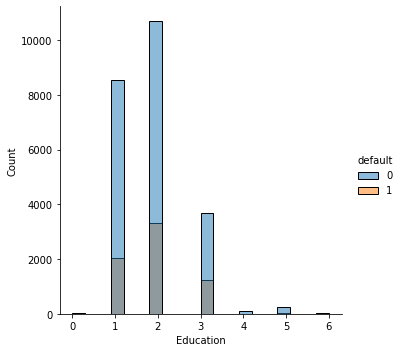

In [46]:
# comparing default subset with non-default subsets: Education
sn.displot(df, x="EDUCATION", hue="default", bins=20)
plt.xlabel("Education")

Text(0.5, 6.799999999999933, 'Marriage')

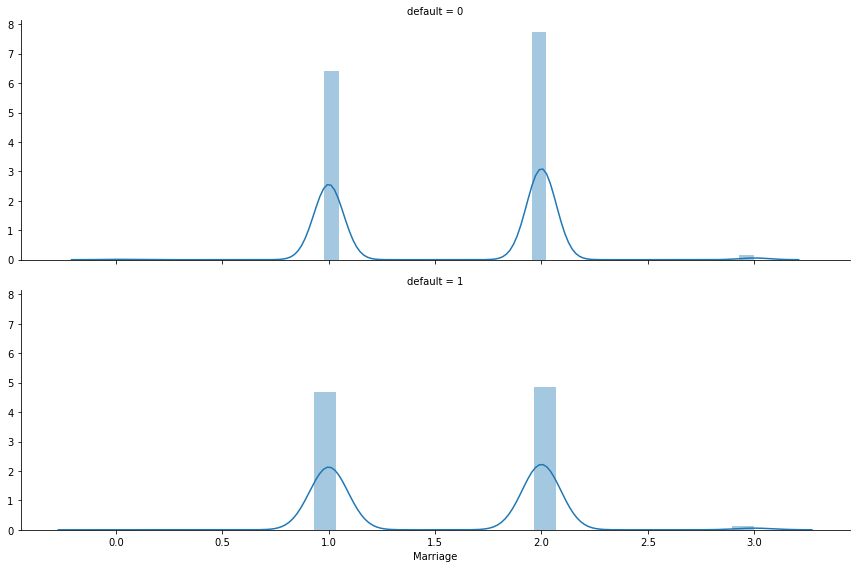

In [19]:
# distribution plots comparing default subset with non-default subsets:  Marriage
mar = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
mar.map(sn.distplot, 'MARRIAGE')
plt.xlabel("Marriage")

Text(0.5, 6.79999999999999, 'Marriage')

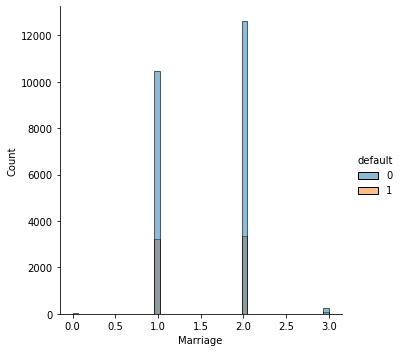

In [47]:
# comparing default subset with non-default subsets: Marriage
sn.displot(df, x="MARRIAGE", hue="default")
plt.xlabel("Marriage")

Text(0.5, 6.799999999999933, 'Age')

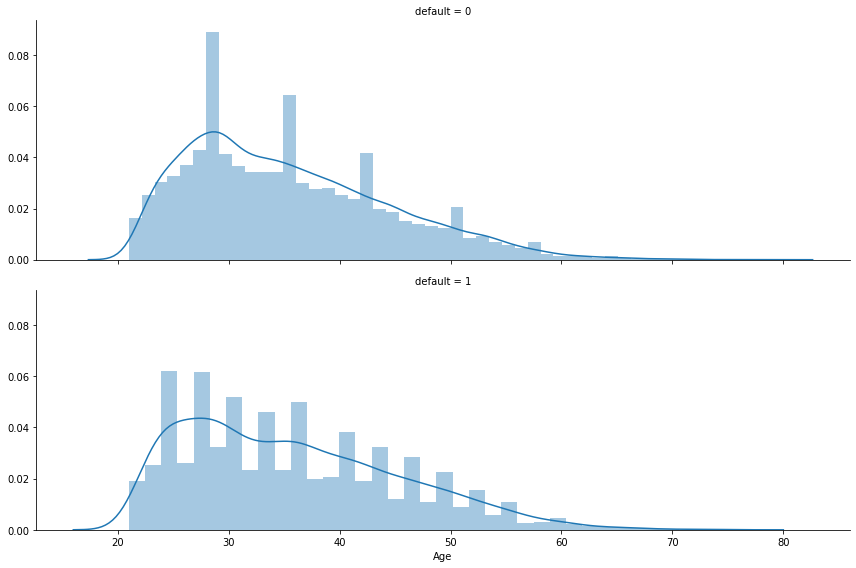

In [20]:
# distribution plots comparing default subset with non-default subsets: Age
age = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
age.map(sn.distplot, 'AGE')
plt.xlabel("Age")

Text(0.5, 6.79999999999999, 'Age')

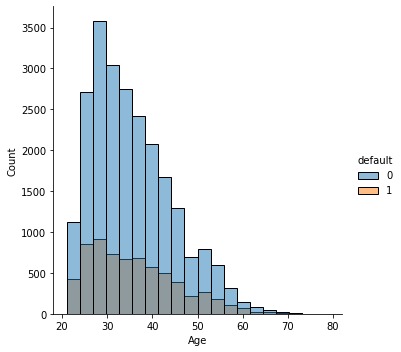

In [48]:
# comparing default subset with non-default subsets: Age
sn.displot(df, x="AGE", hue="default", bins=20)
plt.xlabel("Age")

### Payment variables do show some distinction between default vs non-default subsets.

Text(0.5, 6.799999999999933, 'Pay Status September')

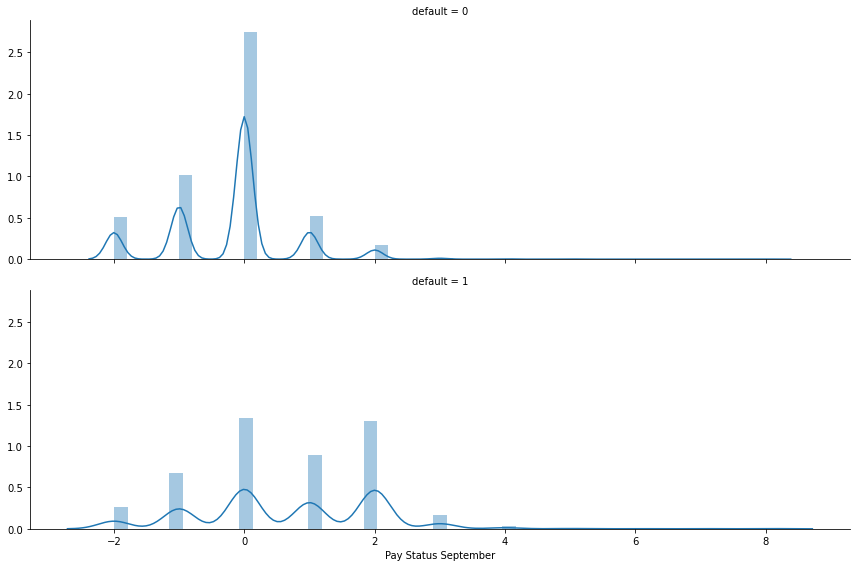

In [21]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 1
p1 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
p1.map(sn.distplot, 'PAY_1')
plt.xlabel("Pay Status September")

**The monthly repayment status distributions showed distinctions between the default records and the non-default records.  The distributions show that the subset of default records have higher counts in those variables that represent that the account holder was late on repaying the account balance than the subset of non-default records.  In fact, even though there are 3.5 times as many non-default records as default records, the default subset has higher counts than the non-default subset in some instances.**

Text(0.5, 1.0, 'Compare September Repayment Status')

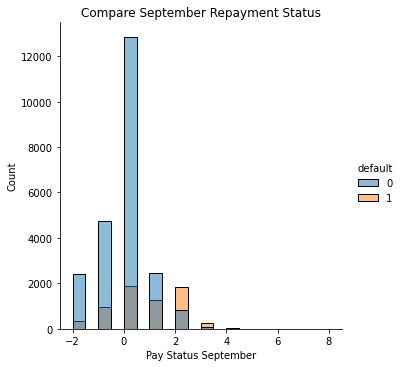

In [50]:
# comparing default subset with non-default subsets: Pay Status 1
sn.displot(df, x="PAY_1", hue="default", bins=20)
plt.xlabel("Pay Status September")
plt.title("Compare September Repayment Status")

Text(0.5, 6.799999999999933, 'Pay Status August')

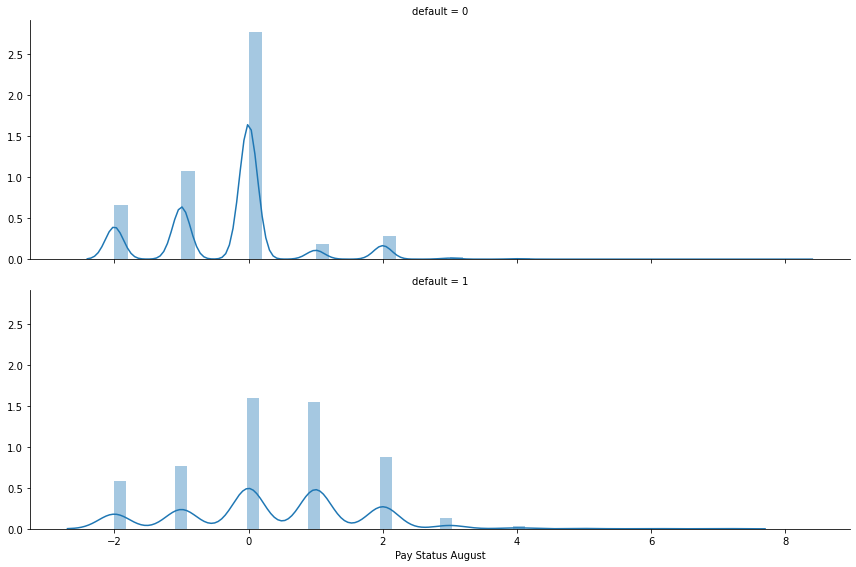

In [22]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 2
pay2 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
pay2.map(sn.distplot, 'PAY_2')
plt.xlabel("Pay Status August")

Text(0.5, 6.79999999999999, 'Pay Status August')

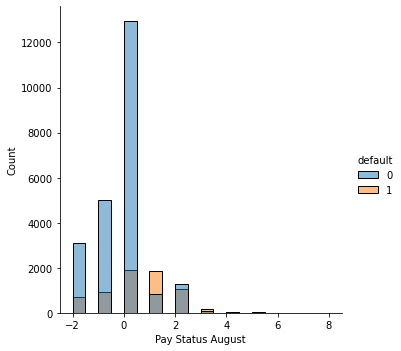

In [51]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 2
sn.displot(df, x="PAY_2", hue="default", bins=20)
plt.xlabel("Pay Status August")

Text(0.5, 6.799999999999933, 'Pay Status July')

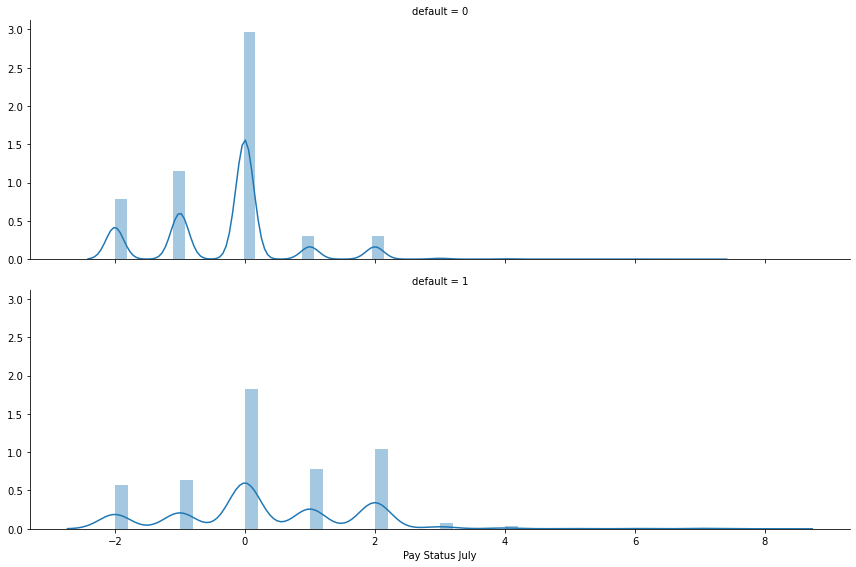

In [23]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 3
pay3 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
pay3.map(sn.distplot, 'PAY_3')
plt.xlabel("Pay Status July")

Text(0.5, 6.79999999999999, 'Pay Status July')

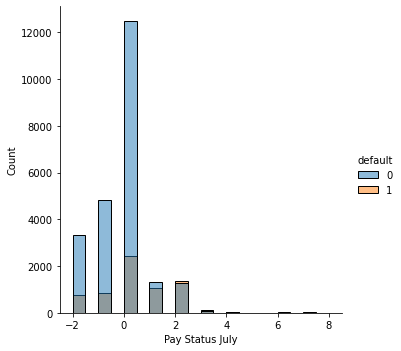

In [52]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 3
sn.displot(df, x="PAY_3", hue="default", bins=20)
plt.xlabel("Pay Status July")

Text(0.5, 6.799999999999933, 'Pay Status June')

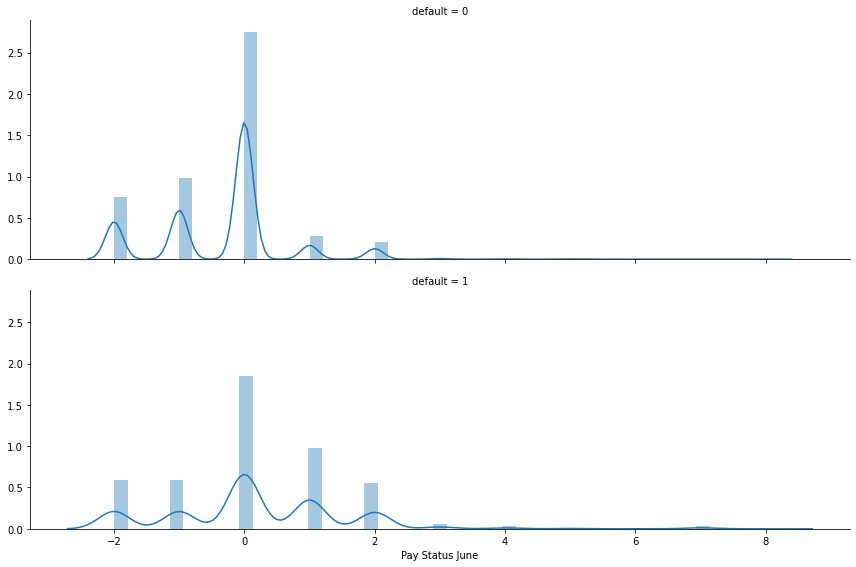

In [24]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 4
pay4 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
pay4.map(sn.distplot, 'PAY_4')
plt.xlabel("Pay Status June")

Text(0.5, 6.79999999999999, 'Pay Status June')

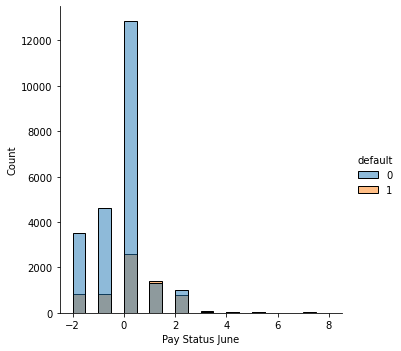

In [53]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 4
sn.displot(df, x="PAY_4", hue="default", bins=20)
plt.xlabel("Pay Status June")

Text(0.5, 6.799999999999933, 'Pay Status May')

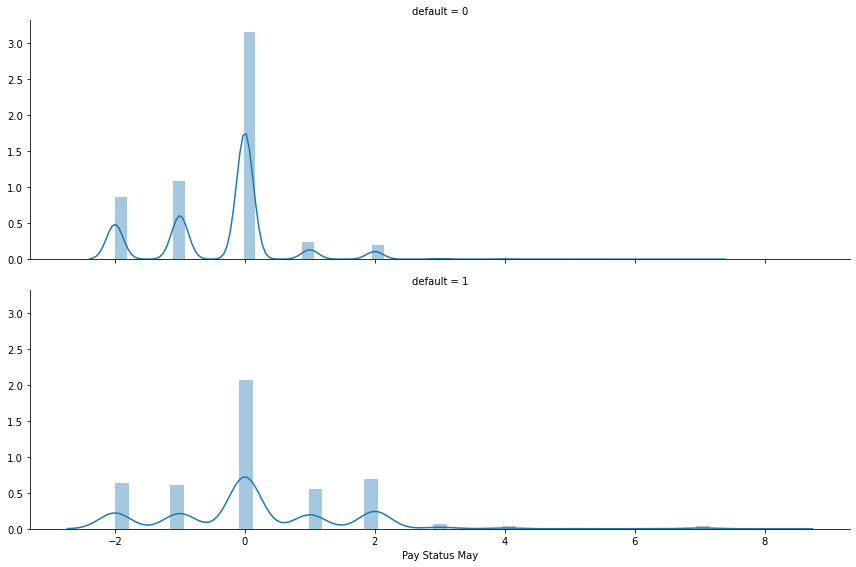

In [25]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 5
pay5 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
pay5.map(sn.distplot, 'PAY_5')
plt.xlabel("Pay Status May")

Text(0.5, 6.79999999999999, 'Pay Status May')

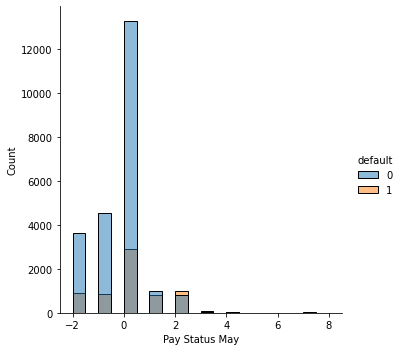

In [54]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 5
sn.displot(df, x="PAY_5", hue="default", bins=20)
plt.xlabel("Pay Status May")

Text(0.5, 6.799999999999933, 'Pay Status April')

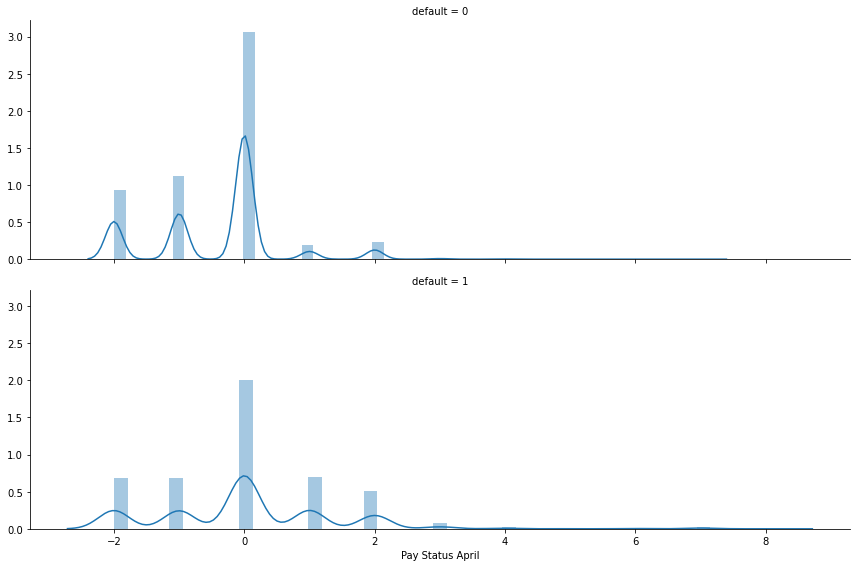

In [27]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 6
pay6 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
pay6.map(sn.distplot, 'PAY_6')
plt.xlabel("Pay Status April")

Text(0.5, 6.79999999999999, 'Pay Status April')

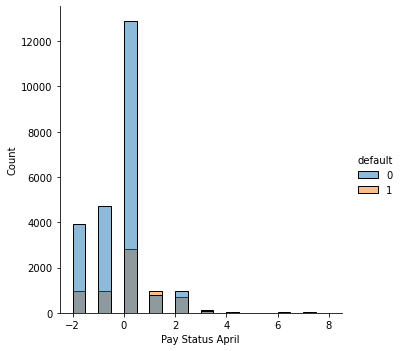

In [55]:
# distribution plots comparing default subset with non-default subsets:  Pay Status 6
sn.displot(df, x="PAY_6", hue="default", bins=20)
plt.xlabel("Pay Status April")

Text(0.5, 6.799999999999933, 'Bill Amount September')

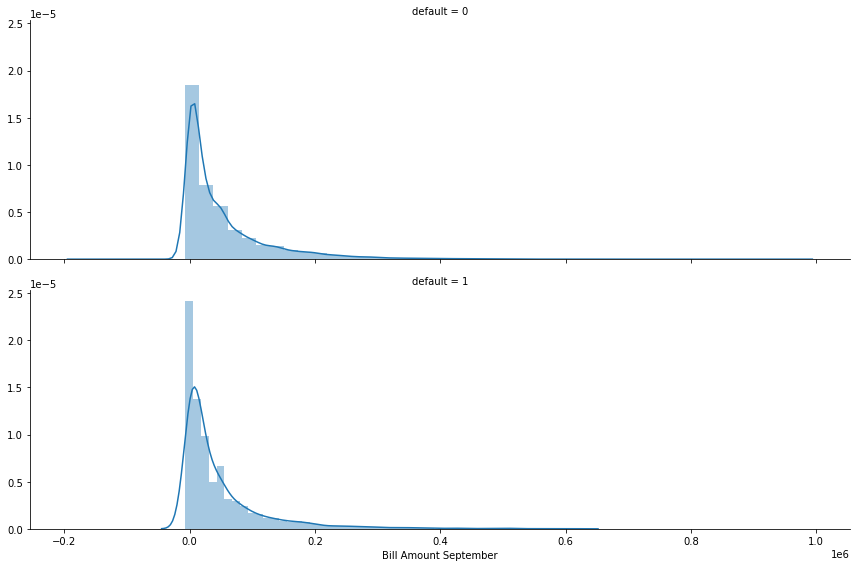

In [28]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 1
bill1 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill1.map(sn.distplot, 'BILL_AMT1')
plt.xlabel("Bill Amount September")

Text(0.5, 6.79999999999999, 'Bill Amount September')

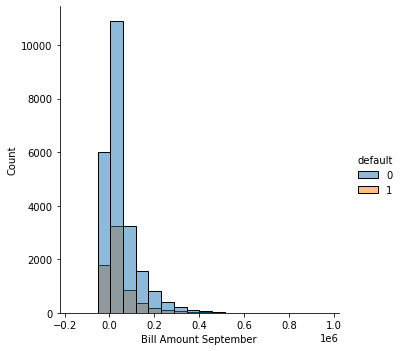

In [56]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount
sn.displot(df, x="BILL_AMT1", hue="default", bins=20)
plt.xlabel("Bill Amount September")

Text(0.5, 6.799999999999933, 'Bill Amount August')

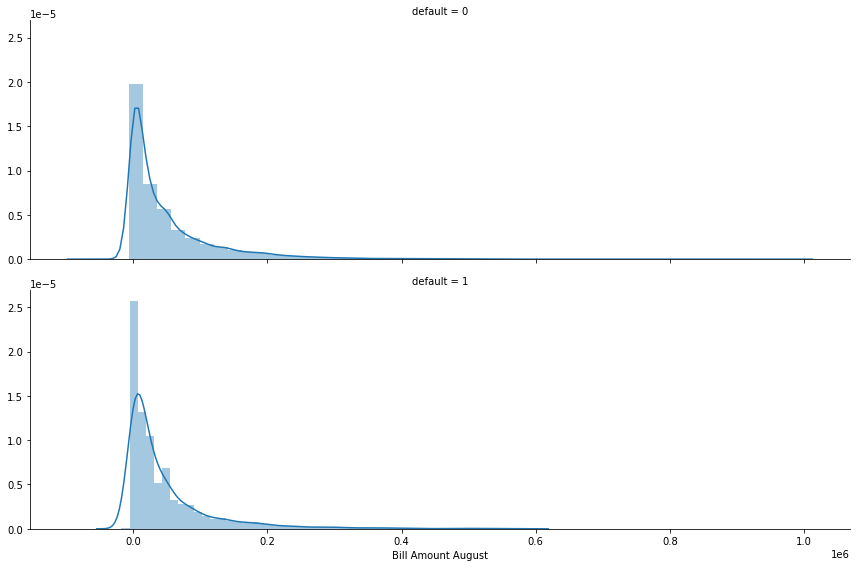

In [29]:
# distribution plots comparing default subset with non-default subsets: Bill Amount 2 
bill2 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill2.map(sn.distplot, 'BILL_AMT2')
plt.xlabel("Bill Amount August")

Text(0.5, 6.79999999999999, 'Bill Amount August')

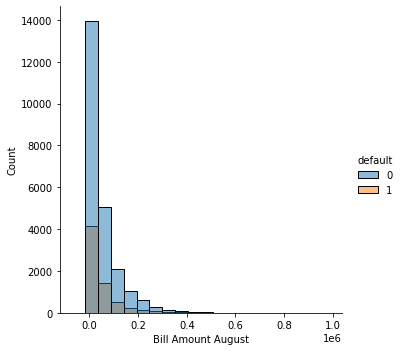

In [57]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 2
sn.displot(df, x="BILL_AMT2", hue="default", bins=20)
plt.xlabel("Bill Amount August")

Text(0.5, 6.799999999999933, 'Bill Amount July')

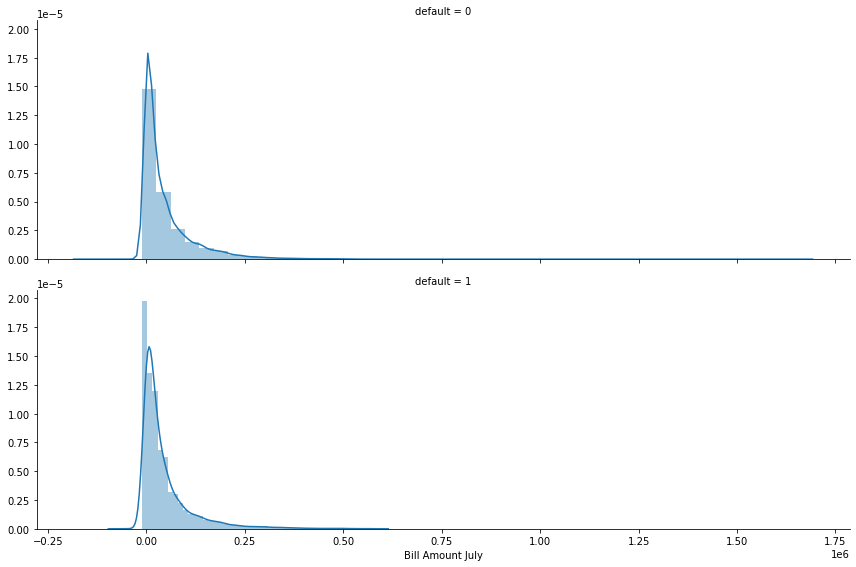

In [30]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 3
bill3 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill3.map(sn.distplot, 'BILL_AMT3')
plt.xlabel("Bill Amount July")

Text(0.5, 6.79999999999999, 'Bill Amount July')

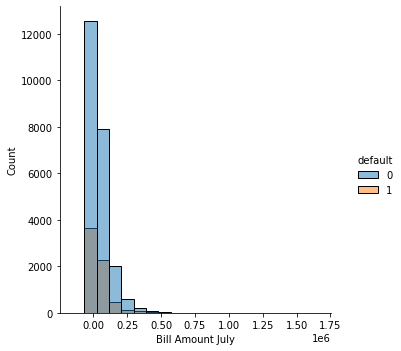

In [58]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 3
sn.displot(df, x="BILL_AMT3", hue="default", bins=20)
plt.xlabel("Bill Amount July")

Text(0.5, 6.799999999999933, 'Bill Amount June')

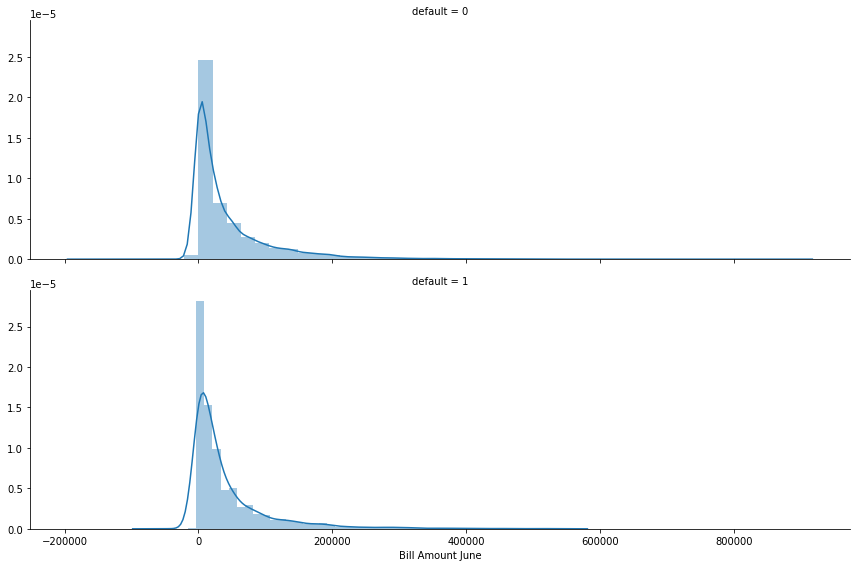

In [33]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 4
bill4 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill4.map(sn.distplot, 'BILL_AMT4')
plt.xlabel("Bill Amount June")

Text(0.5, 6.79999999999999, 'Bill Amount June')

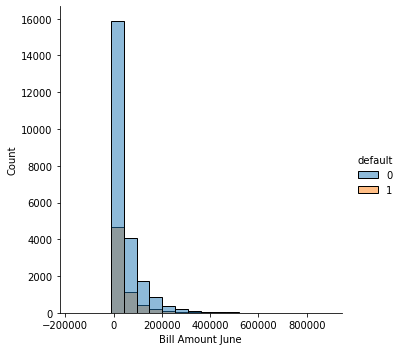

In [59]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 4
sn.displot(df, x="BILL_AMT4", hue="default", bins=20)
plt.xlabel("Bill Amount June")

Text(0.5, 6.799999999999933, 'Bill Amount May')

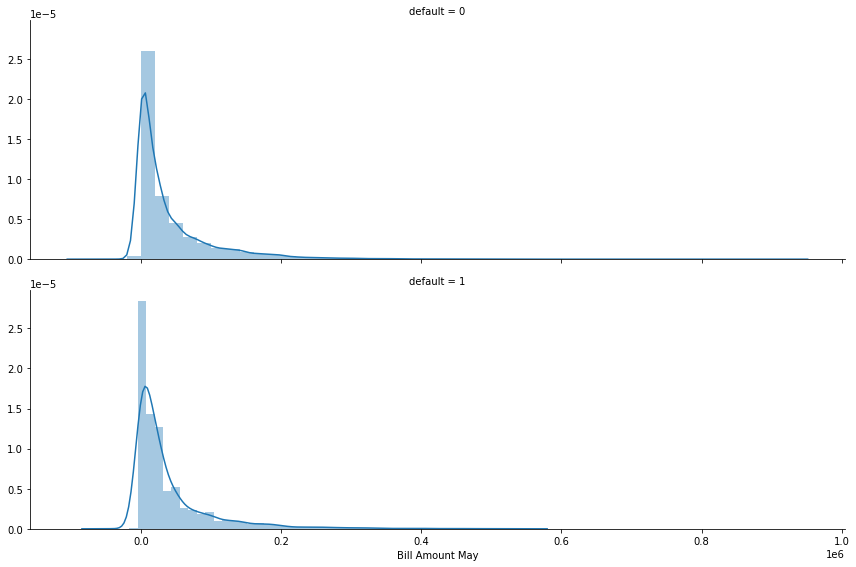

In [34]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 5
bill5 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill5.map(sn.distplot, 'BILL_AMT5')
plt.xlabel("Bill Amount May")

Text(0.5, 6.79999999999999, 'Bill Amount May')

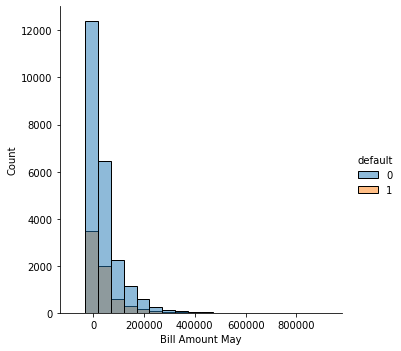

In [60]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 5
sn.displot(df, x="BILL_AMT5", hue="default", bins=20)
plt.xlabel("Bill Amount May")

Text(0.5, 6.799999999999933, 'Bill Amount April')

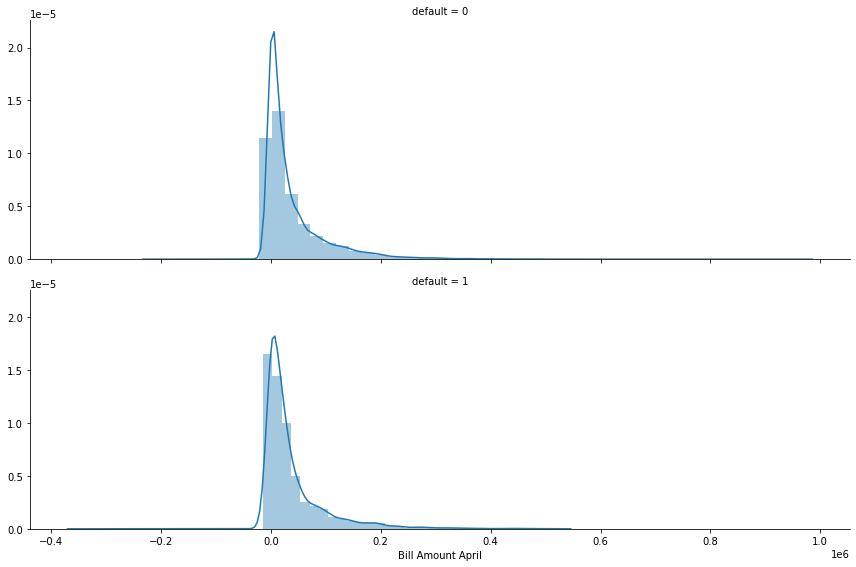

In [36]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 6
bill6 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
bill6.map(sn.distplot, 'BILL_AMT6')
plt.xlabel("Bill Amount April")

Text(0.5, 6.79999999999999, 'Bill Amount April')

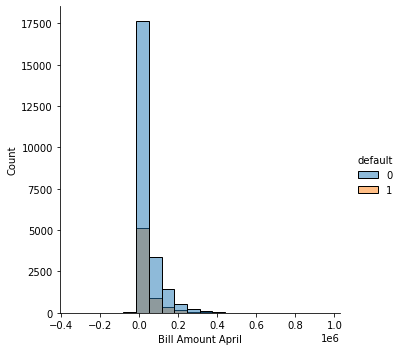

In [61]:
# distribution plots comparing default subset with non-default subsets:  Bill Amount 6
sn.displot(df, x="BILL_AMT6", hue="default", bins=20)
plt.xlabel("Bill Amount April")

Text(0.5, 6.799999999999933, 'Pay Amount September')

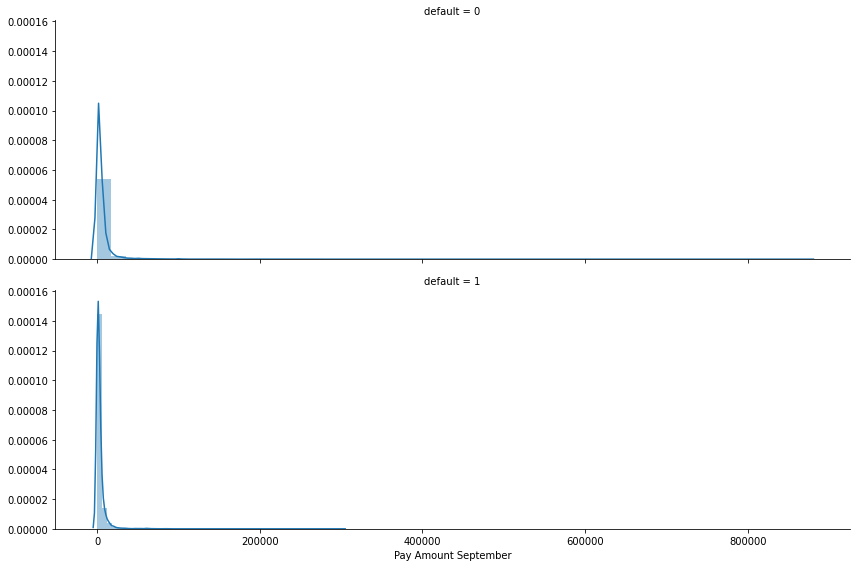

In [37]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 1
amt1 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt1.map(sn.distplot, 'PAY_AMT1')
plt.xlabel("Pay Amount September")

Text(0.5, 6.79999999999999, 'Pay Amount September')

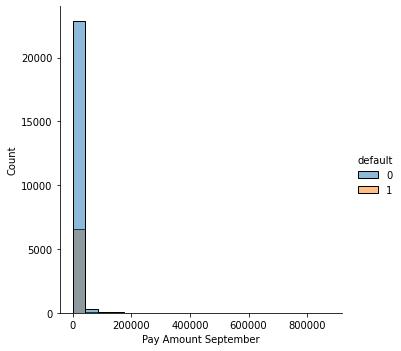

In [62]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 1
sn.displot(df, x="PAY_AMT1", hue="default", bins=20)
plt.xlabel("Pay Amount September")

Text(0.5, 6.799999999999933, 'Pay Amount August')

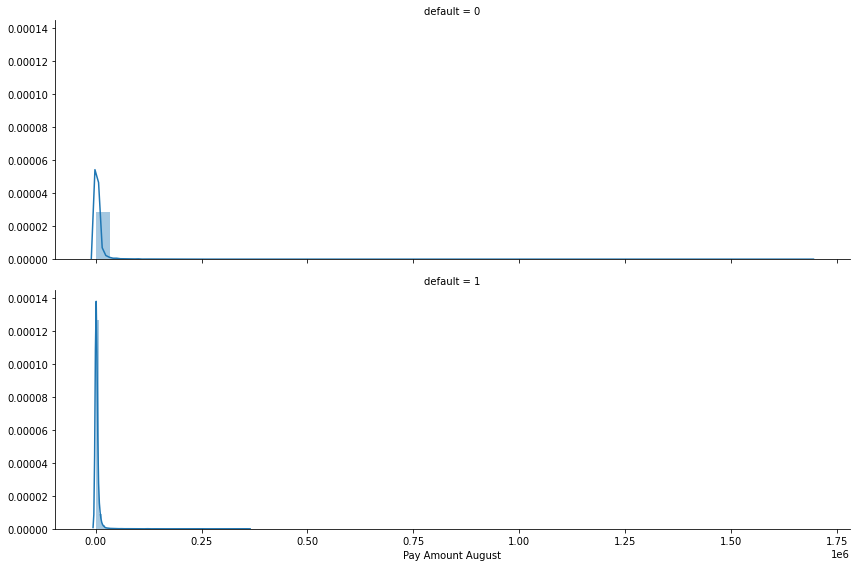

In [38]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 2
amt2 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt2.map(sn.distplot, 'PAY_AMT2')
plt.xlabel("Pay Amount August")

Text(0.5, 6.79999999999999, 'Pay Amount August')

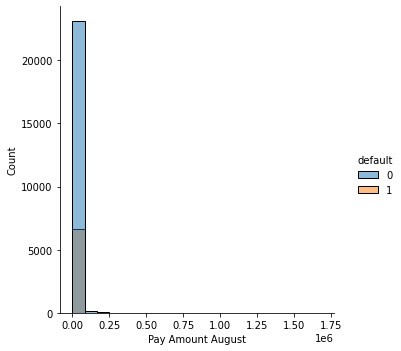

In [63]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 2
sn.displot(df, x="PAY_AMT2", hue="default", bins=20)
plt.xlabel("Pay Amount August")

Text(0.5, 6.799999999999933, 'Pay Amount July')

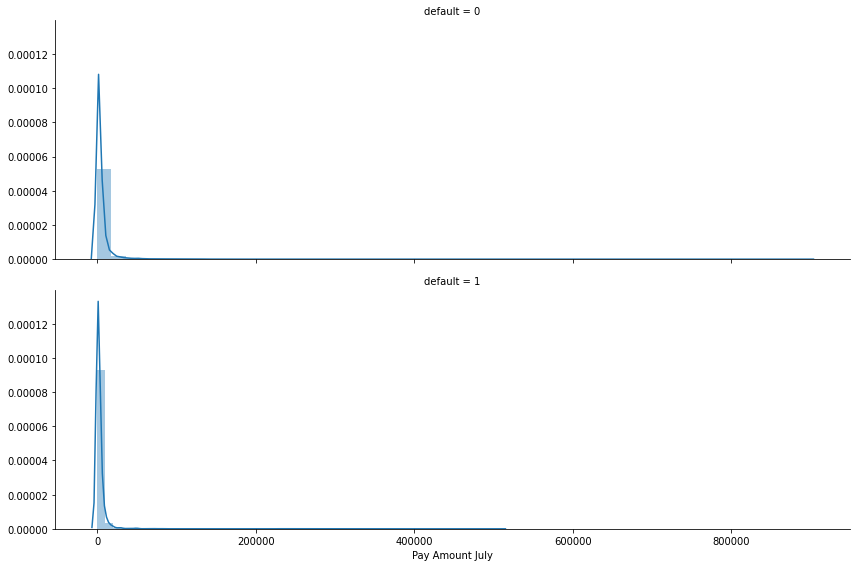

In [39]:
# distribution plots comparing default subset with non-default subsets: Pay Amount 3 
amt3 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt3.map(sn.distplot, 'PAY_AMT3')
plt.xlabel("Pay Amount July")

Text(0.5, 6.79999999999999, 'Pay Amount July')

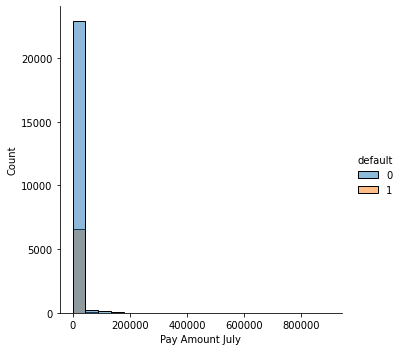

In [64]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 3
sn.displot(df, x="PAY_AMT3", hue="default", bins=20)
plt.xlabel("Pay Amount July")

Text(0.5, 6.799999999999933, 'Pay Amount June')

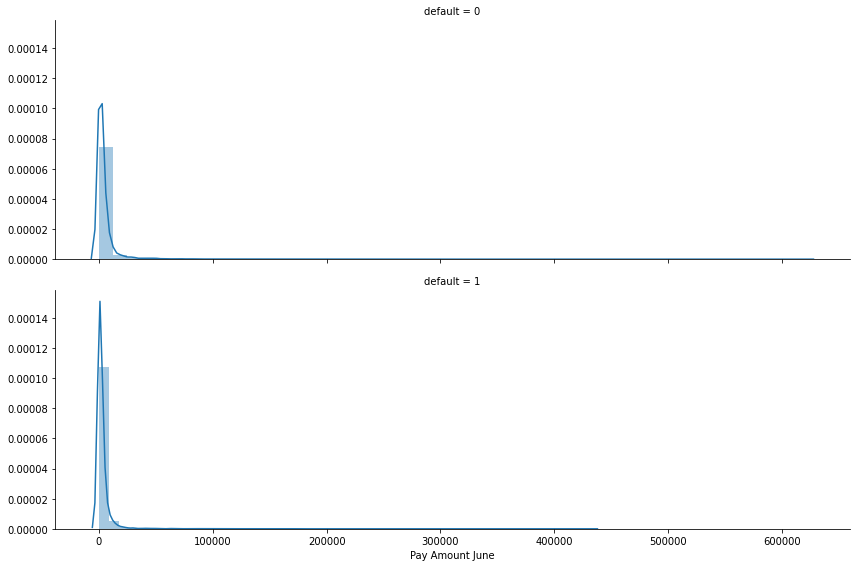

In [40]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 4
amt4 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt4.map(sn.distplot, 'PAY_AMT4')
plt.xlabel("Pay Amount June")

Text(0.5, 6.79999999999999, 'Pay Amount June')

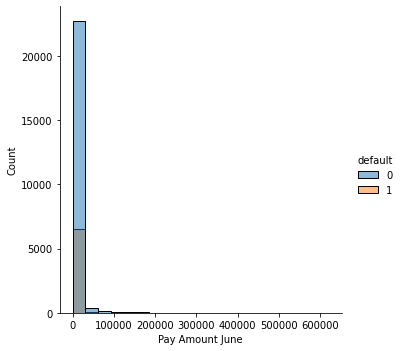

In [69]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 4
sn.displot(df, x="PAY_AMT4", hue="default", bins=20)
plt.xlabel("Pay Amount June")

Text(0.5, 6.799999999999933, 'Pay Amount May')

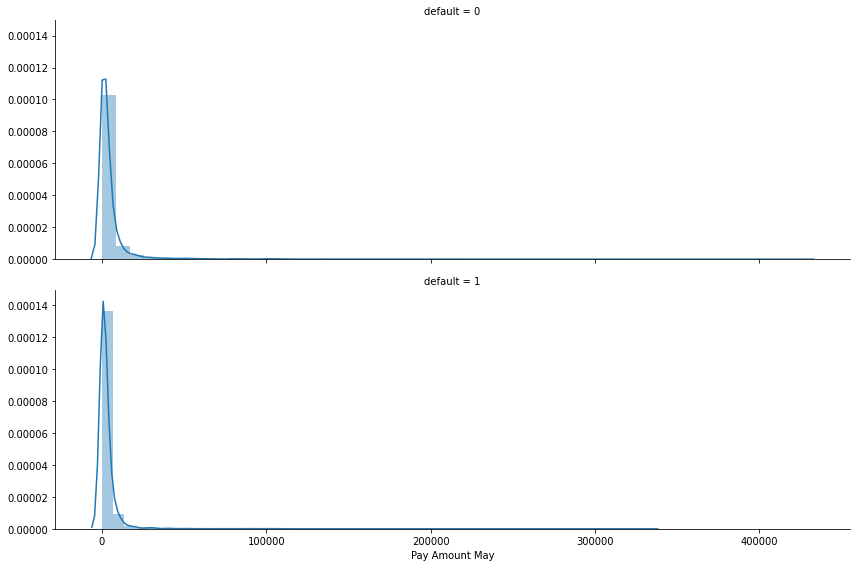

In [41]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 5
amt5 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt5.map(sn.distplot, 'PAY_AMT5')
plt.xlabel("Pay Amount May")

Text(0.5, 6.79999999999999, 'Pay Amount May')

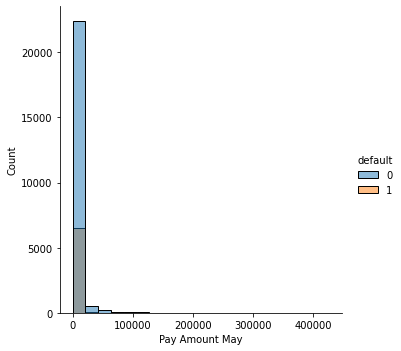

In [68]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 5
sn.displot(df, x="PAY_AMT5", hue="default", bins=20)
plt.xlabel("Pay Amount May")

Text(0.5, 6.799999999999933, 'Pay Amount April')

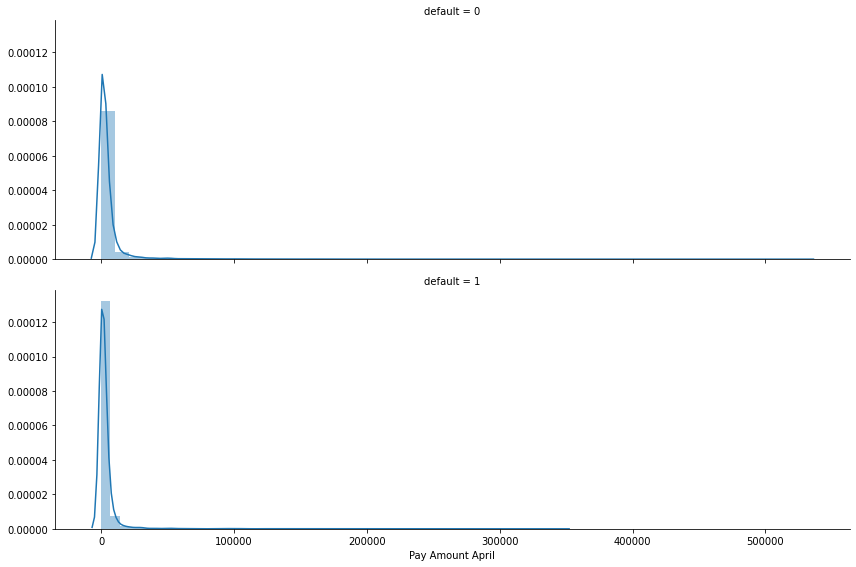

In [42]:
# distribution plots comparing default subset with non-default subsets: Pay Amount 6 
amt6 = sn.FacetGrid(df, row="default", 
                  height=4.0, aspect=3,)
amt6.map(sn.distplot, 'PAY_AMT6')
plt.xlabel("Pay Amount April")

Text(0.5, 6.79999999999999, 'Pay Amount April')

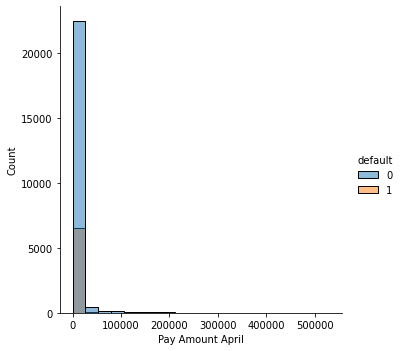

In [67]:
# distribution plots comparing default subset with non-default subsets:  Pay Amount 6
sn.displot(df, x="PAY_AMT6", hue="default", bins=20)
plt.xlabel("Pay Amount April")

### Empirical Cumulative Distribution Plots

**The below cumulative distribution plot also shows this distinction in credit limit values.  It shows that across the entire distribution customers that defaulted had lower credit limits than customers that did not default.**

[Text(0.5, 0, 'Credit Limit Balance'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Credit Limit Balance Empirical Cumulative Distribution')]

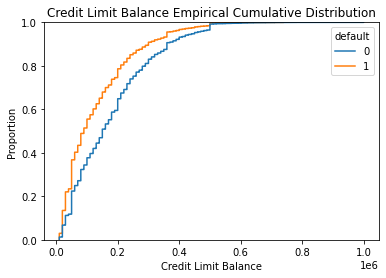

In [82]:
# ECD plots comparing default subset with non-default subsets: Credit Limit Balance  
ax = sn.ecdfplot(data=df, x="LIMIT_BAL", hue="default")
ax.set(xlabel='Credit Limit Balance', ylabel='Proportion', title='Credit Limit Balance Empirical Cumulative Distribution')

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Age Empirical Cumulative Distribution')]

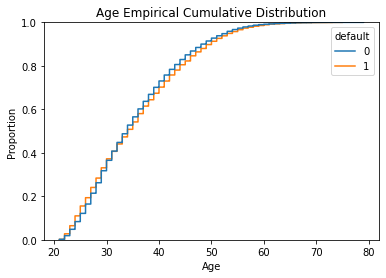

In [83]:
# ECD plots comparing default subset with non-default subsets: Age  
ax = sn.ecdfplot(data=df, x="AGE", hue="default")
ax.set(xlabel='Age', ylabel='Proportion', title='Age Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status September'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status September Empirical Cumulative Distribution')]

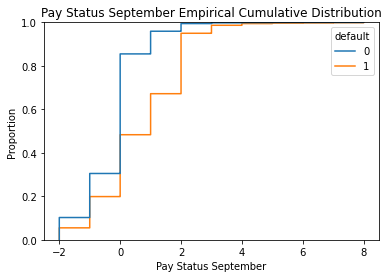

In [85]:
# ECD plots comparing default subset with non-default subsets: Pay status 1
ax = sn.ecdfplot(data=df, x="PAY_1", hue="default")
ax.set(xlabel='Pay Status September', ylabel='Proportion', title='Pay Status September Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status August'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status August Empirical Cumulative Distribution')]

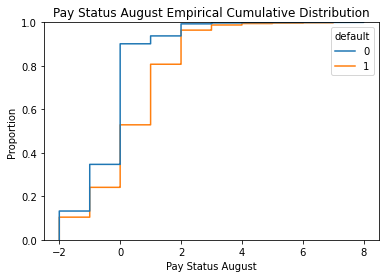

In [86]:
# ECD plots comparing default subset with non-default subsets: Pay status 2
ax = sn.ecdfplot(data=df, x="PAY_2", hue="default")
ax.set(xlabel='Pay Status August', ylabel='Proportion', title='Pay Status August Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status July'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status July Empirical Cumulative Distribution')]

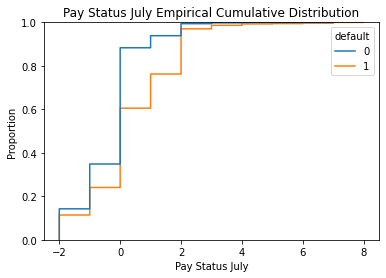

In [87]:
# ECD plots comparing default subset with non-default subsets: Pay status 3
ax = sn.ecdfplot(data=df, x="PAY_3", hue="default")
ax.set(xlabel='Pay Status July', ylabel='Proportion', title='Pay Status July Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status June'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status June Empirical Cumulative Distribution')]

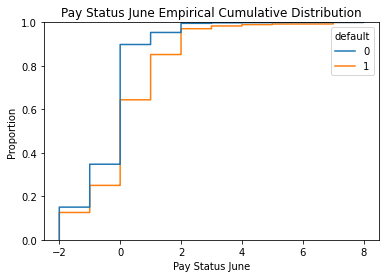

In [88]:
# ECD plots comparing default subset with non-default subsets: Pay status 4 
ax = sn.ecdfplot(data=df, x="PAY_4", hue="default")
ax.set(xlabel='Pay Status June', ylabel='Proportion', title='Pay Status June Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status May'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status May Empirical Cumulative Distribution')]

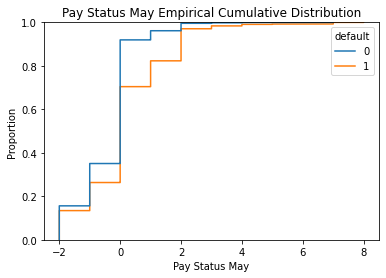

In [89]:
# ECD plots comparing default subset with non-default subsets: Pay status 5 
ax = sn.ecdfplot(data=df, x="PAY_5", hue="default")
ax.set(xlabel='Pay Status May', ylabel='Proportion', title='Pay Status May Empirical Cumulative Distribution')

[Text(0.5, 0, 'Pay Status April'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Pay Status April Empirical Cumulative Distribution')]

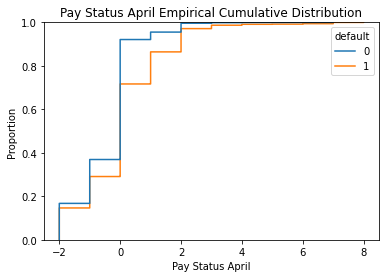

In [84]:
# ECD plots comparing default subset with non-default subsets: Pay status 6 
ax = sn.ecdfplot(data=df, x="PAY_6", hue="default")
ax.set(xlabel='Pay Status April', ylabel='Proportion', title='Pay Status April Empirical Cumulative Distribution')

[Text(0.5, 0, 'Bill Amount August'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Bill Amount August Empirical Cumulative Distribution')]

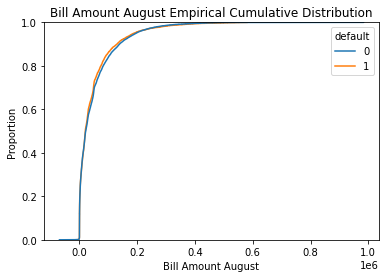

In [91]:
# ECD plots comparing default subset with non-default subsets: Bill Amount 2
ax = sn.ecdfplot(data=df, x="BILL_AMT2", hue="default")
ax.set(xlabel='Bill Amount August', ylabel='Proportion', title='Bill Amount August Empirical Cumulative Distribution')

[Text(0.5, 0, 'Bill Amount September'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Bill Amount September Empirical Cumulative Distribution')]

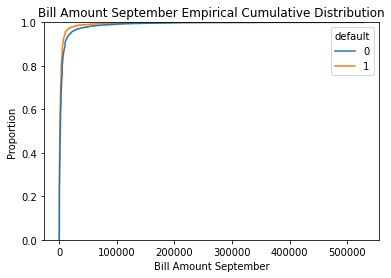

In [94]:
# ECD plots comparing default subset with non-default subsets: Pay Amount 6
ax = sn.ecdfplot(data=df, x="PAY_AMT6", hue="default")
ax.set(xlabel='Bill Amount September', ylabel='Proportion', title='Bill Amount September Empirical Cumulative Distribution')

## Descriptive Statistics

In [89]:
# Create new dataset with quantitative variables - full dataset
df_quant = df.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'], axis=1)
df_quant.describe()


,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.155700,-0.161200,-0.221400,-0.263633,-0.305633,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.127253,1.152675,1.114252,1.100290,1.100725,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [90]:
df_quant.shape

(30000, 21)

## Create correlation visuals to see strength of correlation of each variable with the target "default" variable.

In [91]:
features_quant = [ 'default', 'LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

**Full Dataset**

array([[1.0000e+00, 5.0000e+04, 2.9000e+01, ..., 2.2250e+03, 1.2000e+03,
        0.0000e+00],
       [1.0000e+00, 3.2000e+05, 2.9000e+01, ..., 4.8000e+03, 2.4000e+03,
        1.6000e+03],
       [1.0000e+00, 2.0000e+05, 5.3000e+01, ..., 5.5000e+03, 5.0000e+03,
        5.0000e+03],
       ...,
       [0.0000e+00, 1.5000e+05, 4.3000e+01, ..., 1.2900e+02, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 8.0000e+04, 4.1000e+01, ..., 1.9260e+03, 5.2964e+04,
        1.8040e+03],
       [1.0000e+00, 5.0000e+04, 4.6000e+01, ..., 1.0000e+03, 1.0000e+03,
        1.0000e+03]])

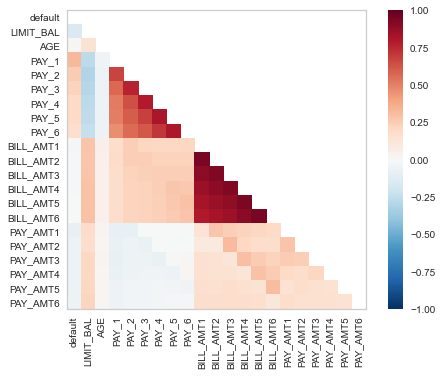

In [92]:
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_quant].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_quant, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
#visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data

**Subset of Default Only Records**

array([[1.0000e+00, 5.0000e+04, 2.9000e+01, ..., 2.2250e+03, 1.2000e+03,
        0.0000e+00],
       [1.0000e+00, 3.2000e+05, 2.9000e+01, ..., 4.8000e+03, 2.4000e+03,
        1.6000e+03],
       [1.0000e+00, 2.0000e+05, 5.3000e+01, ..., 5.5000e+03, 5.0000e+03,
        5.0000e+03],
       ...,
       [1.0000e+00, 9.0000e+04, 3.6000e+01, ..., 1.2000e+03, 2.5000e+03,
        0.0000e+00],
       [1.0000e+00, 8.0000e+04, 4.1000e+01, ..., 1.9260e+03, 5.2964e+04,
        1.8040e+03],
       [1.0000e+00, 5.0000e+04, 4.6000e+01, ..., 1.0000e+03, 1.0000e+03,
        1.0000e+03]])

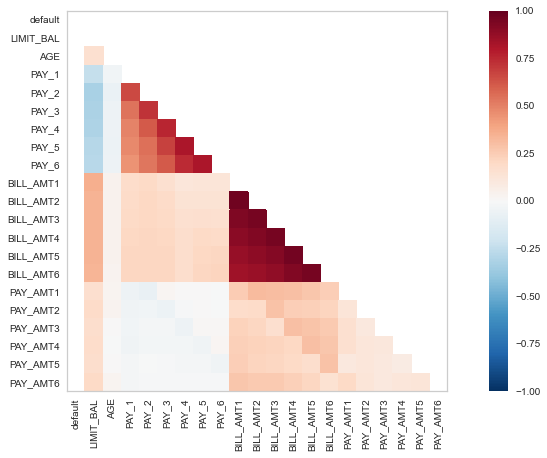

In [93]:
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =defaultY[features_quant].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_quant, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
#visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data

**Subset of Non-Default Records Only**

array([[0.000e+00, 6.000e+04, 2.600e+01, ..., 6.000e+00, 3.000e+03,
        3.000e+03],
       [0.000e+00, 2.800e+05, 4.100e+01, ..., 1.485e+04, 0.000e+00,
        5.000e+03],
       [0.000e+00, 3.000e+04, 4.100e+01, ..., 0.000e+00, 1.200e+03,
        1.250e+03],
       ...,
       [0.000e+00, 1.000e+05, 3.800e+01, ..., 3.000e+03, 2.000e+03,
        2.000e+03],
       [0.000e+00, 2.200e+05, 3.900e+01, ..., 3.047e+03, 5.000e+03,
        1.000e+03],
       [0.000e+00, 1.500e+05, 4.300e+01, ..., 1.290e+02, 0.000e+00,
        0.000e+00]])

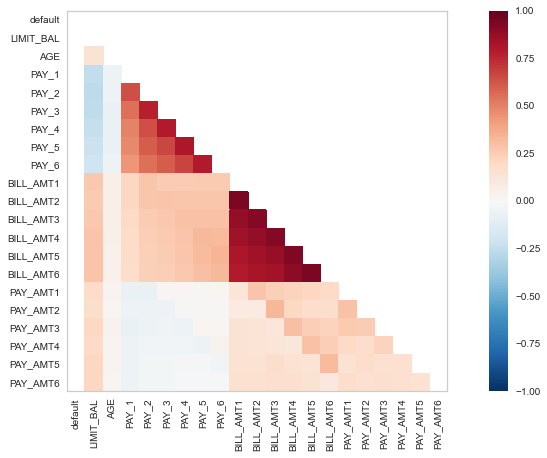

In [94]:
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =defaultN[features_quant].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_quant, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
#visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data

### Look at descriptive statistics for separate default subset and non-default subset.

**The mean of the repayment status is higher for default records in every month, but the means of the default subset bill amounts and previous payment variables are less than the means of the non-default subset in every month.**

In [102]:
# Create new dataset with quantitative variables - default is yes
defaultY_quant = defaultY.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)
defaultY_quant.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000
mean,130109.656420,35.725738,0.668174,0.376582,0.337251,0.199367,0.145118,0.046866,48509.162297,47283.617842,45181.598855,42036.950573,39540.190476,38271.435503,3397.044153,3388.649638,3367.351567,3155.626733,3219.139542,3441.482068
std,115378.540571,9.693438,1.383252,1.353213,1.412146,1.387491,1.414174,1.381022,73782.067220,71651.030364,68516.975738,64351.076092,61424.695949,59579.674268,9544.252427,11737.986064,12959.624486,11191.973162,11944.731175,13464.005894
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-6676.000000,-17710.000000,-61506.000000,-65167.000000,-53007.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,2987.750000,2694.000000,2500.000000,2141.500000,1502.750000,1150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,90000.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20185.000000,20300.500000,19834.500000,19119.500000,18478.500000,18028.500000,1636.000000,1533.500000,1222.000000,1000.000000,1000.000000,1000.000000
75%,200000.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,59626.500000,57919.750000,54733.750000,50175.750000,47853.000000,47424.000000,3478.250000,3309.750000,3000.000000,2939.250000,3000.000000,2974.500000
max,740000.000000,75.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,613860.000000,581775.000000,578971.000000,548020.000000,547880.000000,514975.000000,300000.000000,358689.000000,508229.000000,432130.000000,332000.000000,345293.000000


In [110]:
# Create new dataset with quantitative variables - default is no
defaultN_quant = defaultN.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)
defaultN_quant.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,2.336400e+04,23364.000000,23364.000000,23364.000000,23364.000000,2.336400e+04,23364.000000,23364.000000,23364.000000,23364.000000
mean,178099.726074,35.417266,-0.211222,-0.306882,-0.302773,-0.340909,-0.379729,-0.405752,51994.227273,49717.435670,4.753337e+04,43611.165254,40530.445343,39042.268704,6307.337357,6.640465e+03,5753.496833,5300.529319,5248.220296,5719.371769
std,131628.359660,9.077355,0.952464,1.004115,1.024257,0.991417,0.962087,0.984263,73577.606694,71029.946709,6.957666e+04,64324.796730,60617.268112,59547.015717,18014.508990,2.530226e+04,18684.255937,16689.778060,16071.667860,18792.950473
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,70000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3677.250000,3055.000000,2.769750e+03,2360.000000,1823.000000,1265.500000,1163.750000,1.005000e+03,600.000000,390.000000,369.000000,300.000000
50%,150000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23119.500000,21660.500000,2.020250e+04,19000.000000,17998.000000,16679.000000,2459.500000,2.247500e+03,2000.000000,1734.000000,1765.000000,1706.000000
75%,250000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69027.000000,65686.000000,6.189400e+04,55988.000000,51135.250000,49842.500000,5606.250000,5.311250e+03,5000.000000,4602.000000,4600.000000,4545.000000
max,1000000.000000,79.000000,8.000000,8.000000,7.000000,8.000000,7.000000,7.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


### Look at differences in means of PAY variables between default and non-default subsets.

In [123]:
# create dataframe of mean statistics for the PAY columns
meanY = defaultY_quant.describe(include='all').loc['mean']
meanN = defaultN_quant.describe(include='all').loc['mean']
mdf = pd.concat([meanY, meanN], axis=1)
mdf.columns = ['meanY', 'meanN']
meandf = mdf.loc[['PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], :]
meandf.head()

,meanY,meanN
PAY_1,0.668174,-0.211222
PAY_2,0.376582,-0.306882
PAY_3,0.337251,-0.302773
PAY_4,0.199367,-0.340909
PAY_5,0.145118,-0.379729


In [125]:
meandf2 = meandf.iloc[::-1]
meandf2.head()

,meanY,meanN
PAY_6,0.046866,-0.405752
PAY_5,0.145118,-0.379729
PAY_4,0.199367,-0.340909
PAY_3,0.337251,-0.302773
PAY_2,0.376582,-0.306882


In [126]:
meandf2['Month'] = ['April', 'May', 'June', 'July', 'August', 'September']
meandf2.head()

,meanY,meanN,Month
PAY_6,0.046866,-0.405752,April
PAY_5,0.145118,-0.379729,May
PAY_4,0.199367,-0.340909,June
PAY_3,0.337251,-0.302773,July
PAY_2,0.376582,-0.306882,August


**Visualize the difference in repayment status mean statistics between default subset and non-default subset**

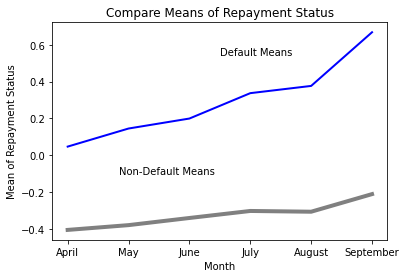

In [128]:
fig, ax = plt.subplots()
ax.text(0.2, 0.3, 'Non-Default Means', transform=ax.transAxes)
ax.text(0.5, 0.85, 'Default Means', transform=ax.transAxes)
ax.plot(meandf2.Month, meandf2['meanY'], marker='', color='blue', linewidth=2)
ax.plot(meandf2.Month, meandf2['meanN'], marker='', color='grey', linewidth=4)
# set details of the graph
ax.set(xlabel='Month', ylabel='Mean of Repayment Status',
       title='Compare Means of Repayment Status')


plt.show()

**Correlation of full dataframe quantitative variables.**

In [97]:
# Create new dataset with quantitative variables - full dataframe
df_quant.corr()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
LIMIT_BAL,1.000000,0.144713,-0.271214,-0.301502,-0.288124,-0.270936,-0.250983,-0.235145,0.285430,0.278314,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
AGE,0.144713,1.000000,-0.039447,-0.055593,-0.055355,-0.055963,-0.056843,-0.049581,0.056239,0.054283,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_1,-0.271214,-0.039447,1.000000,0.678946,0.575945,0.523233,0.510754,0.466680,0.187068,0.189859,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.301502,-0.055593,0.678946,1.000000,0.769792,0.647951,0.605021,0.564962,0.243465,0.243205,...,0.225622,0.222918,0.219505,-0.078500,-0.056359,-0.053706,-0.047214,-0.036362,-0.036397,0.251656
PAY_3,-0.288124,-0.055355,0.575945,0.769792,1.000000,0.790824,0.687099,0.619224,0.216332,0.244147,...,0.233039,0.230060,0.226664,-0.003476,-0.064357,-0.051302,-0.045411,-0.033718,-0.033787,0.230464
PAY_4,-0.270936,-0.055963,0.523233,0.647951,0.790824,1.000000,0.820091,0.711569,0.203508,0.228251,...,0.245133,0.239849,0.234446,-0.001577,-0.006403,-0.063544,-0.041190,-0.030509,-0.024714,0.201254
PAY_5,-0.250983,-0.056843,0.510754,0.605021,0.687099,0.820091,1.000000,0.807292,0.209515,0.229854,...,0.274079,0.271746,0.263818,-0.005532,-0.001172,0.006075,-0.055824,-0.031984,-0.021953,0.197988
PAY_6,-0.235145,-0.049581,0.466680,0.564962,0.619224,0.711569,0.807292,1.000000,0.212651,0.232159,...,0.270272,0.293298,0.286162,0.000332,-0.003170,0.008960,0.020033,-0.044990,-0.021891,0.170673
BILL_AMT1,0.285430,0.056239,0.187068,0.243465,0.216332,0.203508,0.209515,0.212651,1.000000,0.951484,...,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341,-0.019644
BILL_AMT2,0.278314,0.054283,0.189859,0.243205,0.244147,0.228251,0.229854,0.232159,0.951484,1.000000,...,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256,-0.014193


**Create subsets to look at highest correlations between different types of variables (address 6 columns for 3 of the variables).**

In [ ]:
# Create new dataset with quantitative variables - full dataset
df_quant = df.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'], axis=1)

In [158]:
# Create new dataset with selected quantitative variables - full dataset
df_quantSep = df.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1',
        'default'], axis=1)

In [159]:
# Create new dataset with selected quantitative variables - full dataset
df_quantApr = df.filter(['LIMIT_BAL', 'AGE', 'PAY_6', 'BILL_AMT6', 'PAY_AMT6',
        'default'], axis=1)

In [160]:
# Create new dataset with selected quantitative variables - full dataset
dfY_quantSep = defaultY.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1',
        'default'], axis=1)

In [161]:
# Create new dataset with selected quantitative variables - full dataset
dfN_quantSep = defaultN.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1',
        'default'], axis=1)

In [162]:
# Create new dataset with selected quantitative variables - full dataset
dfY_quantApr = defaultY.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1',
        'default'], axis=1)

In [163]:
# Create new dataset with selected quantitative variables - full dataset
dfN_quantApr = defaultN.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1',
        'default'], axis=1)

In [102]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [103]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_quantSep, 20))

Top Absolute Correlations
PAY_1      default      0.324794
LIMIT_BAL  BILL_AMT1    0.285430
           PAY_1        0.271214
           PAY_AMT1     0.195236
PAY_1      BILL_AMT1    0.187068
LIMIT_BAL  default      0.153520
           AGE          0.144713
BILL_AMT1  PAY_AMT1     0.140277
PAY_1      PAY_AMT1     0.079269
PAY_AMT1   default      0.072929
AGE        BILL_AMT1    0.056239
           PAY_1        0.039447
           PAY_AMT1     0.026147
BILL_AMT1  default      0.019644
AGE        default      0.013890
dtype: float64


In [104]:
print("Top Absolute Correlations for April")
print(get_top_abs_correlations(df_quantApr, 20))

Top Absolute Correlations for April
LIMIT_BAL  BILL_AMT6    0.290389
PAY_6      BILL_AMT6    0.286162
LIMIT_BAL  PAY_6        0.235145
           PAY_AMT6     0.219595
PAY_6      default      0.170673
LIMIT_BAL  default      0.153520
           AGE          0.144713
BILL_AMT6  PAY_AMT6     0.115494
PAY_AMT6   default      0.053183
AGE        PAY_6        0.049581
           BILL_AMT6    0.047613
PAY_6      PAY_AMT6     0.021891
AGE        PAY_AMT6     0.019478
           default      0.013890
BILL_AMT6  default      0.005372
dtype: float64


In [164]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(dfY_quantSep, 20))

Top Absolute Correlations
LIMIT_BAL  BILL_AMT1    0.360554
BILL_AMT1  PAY_AMT1     0.253973
LIMIT_BAL  PAY_1        0.237123
PAY_1      BILL_AMT1    0.185440
LIMIT_BAL  PAY_AMT1     0.167616
           AGE          0.160025
PAY_1      PAY_AMT1     0.052821
AGE        BILL_AMT1    0.044896
           PAY_1        0.032551
           PAY_AMT1     0.030329
LIMIT_BAL  default           NaN
AGE        default           NaN
PAY_1      default           NaN
BILL_AMT1  default           NaN
PAY_AMT1   default           NaN
dtype: float64


In [165]:
print("Top Absolute Correlations for April")
print(get_top_abs_correlations(dfY_quantApr, 20))

Top Absolute Correlations for April
LIMIT_BAL  BILL_AMT1    0.360554
BILL_AMT1  PAY_AMT1     0.253973
LIMIT_BAL  PAY_1        0.237123
PAY_1      BILL_AMT1    0.185440
LIMIT_BAL  PAY_AMT1     0.167616
           AGE          0.160025
PAY_1      PAY_AMT1     0.052821
AGE        BILL_AMT1    0.044896
           PAY_1        0.032551
           PAY_AMT1     0.030329
LIMIT_BAL  default           NaN
AGE        default           NaN
PAY_1      default           NaN
BILL_AMT1  default           NaN
PAY_AMT1   default           NaN
dtype: float64


In [166]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(dfN_quantSep, 20))

Top Absolute Correlations
LIMIT_BAL  BILL_AMT1    0.267728
           PAY_1        0.244836
PAY_1      BILL_AMT1    0.216615
LIMIT_BAL  PAY_AMT1     0.192066
           AGE          0.146199
BILL_AMT1  PAY_AMT1     0.125730
PAY_1      PAY_AMT1     0.065882
AGE        BILL_AMT1    0.060091
           PAY_1        0.053293
           PAY_AMT1     0.027688
LIMIT_BAL  default           NaN
AGE        default           NaN
PAY_1      default           NaN
BILL_AMT1  default           NaN
PAY_AMT1   default           NaN
dtype: float64


In [167]:
print("Top Absolute Correlations for April")
print(get_top_abs_correlations(dfN_quantApr, 20))

Top Absolute Correlations for April
LIMIT_BAL  BILL_AMT1    0.267728
           PAY_1        0.244836
PAY_1      BILL_AMT1    0.216615
LIMIT_BAL  PAY_AMT1     0.192066
           AGE          0.146199
BILL_AMT1  PAY_AMT1     0.125730
PAY_1      PAY_AMT1     0.065882
AGE        BILL_AMT1    0.060091
           PAY_1        0.053293
           PAY_AMT1     0.027688
LIMIT_BAL  default           NaN
AGE        default           NaN
PAY_1      default           NaN
BILL_AMT1  default           NaN
PAY_AMT1   default           NaN
dtype: float64


### Point-biserial correlation with binary target and continuous variables.

**Point-biserial correlation is used for correlation between the binary target variable and the continuous predictive variables.  None of the features have strong point-biserial correlations with the default target feature.  However, the correlation of the most recent repayment status value is more closely correlated with the default target variable than any of the other features.**

In [105]:
pbcLIMIT_BAL = stats.pointbiserialr(df.default, df.LIMIT_BAL)
print('Limit Bal: ', pbcLIMIT_BAL)

pbcAGE = stats.pointbiserialr(df.default, df.AGE)
print('Age: ', pbcAGE)



Limit Bal:  PointbiserialrResult(correlation=-0.1535198763935002, pvalue=1.3022439534049927e-157)
Age:  PointbiserialrResult(correlation=0.013889834301963083, pvalue=0.016136845891438788)


In [106]:
pbcPAY_1 = stats.pointbiserialr(df.default, df.PAY_1)
print(pbcPAY_1)

pbcPAY_2 = stats.pointbiserialr(df.default, df.PAY_2)
print(pbcPAY_2)

pbcPAY_3 = stats.pointbiserialr(df.default, df.PAY_3)
print(pbcPAY_3)

pbcPAY_4 = stats.pointbiserialr(df.default, df.PAY_4)
print(pbcPAY_4)

pbcPAY_5 = stats.pointbiserialr(df.default, df.PAY_5)
print(pbcPAY_5)

pbcPAY_6 = stats.pointbiserialr(df.default, df.PAY_6)
print(pbcPAY_6)


PointbiserialrResult(correlation=0.324793728478616, pvalue=0.0)
PointbiserialrResult(correlation=0.2516560312852095, pvalue=0.0)
PointbiserialrResult(correlation=0.2304638794395602, pvalue=0.0)
PointbiserialrResult(correlation=0.2012543619956233, pvalue=1.0700808338728614e-271)
PointbiserialrResult(correlation=0.19798778821209348, pvalue=7.662079791822927e-263)
PointbiserialrResult(correlation=0.1706733918643573, pvalue=7.307791380213848e-195)


In [107]:
pbcBILL_AMT1 = stats.pointbiserialr(df.default, df.BILL_AMT1)
print(pbcBILL_AMT1)

pbcBILL_AMT2 = stats.pointbiserialr(df.default, df.BILL_AMT2)
print(pbcBILL_AMT2)

pbcBILL_AMT3 = stats.pointbiserialr(df.default, df.BILL_AMT3)
print(pbcBILL_AMT3)

pbcBILL_AMT4 = stats.pointbiserialr(df.default, df.BILL_AMT4)
print(pbcBILL_AMT4)

pbcBILL_AMT5 = stats.pointbiserialr(df.default, df.BILL_AMT5)
print(pbcBILL_AMT5)

pbcBILL_AMT6 = stats.pointbiserialr(df.default, df.BILL_AMT6)
print(pbcBILL_AMT6)



PointbiserialrResult(correlation=-0.01964419714322115, pvalue=0.0006673295491749174)
PointbiserialrResult(correlation=-0.014193218088215446, pvalue=0.013957362393566234)
PointbiserialrResult(correlation=-0.014075518043214523, pvalue=0.014769982711883418)
PointbiserialrResult(correlation=-0.010156495880289523, pvalue=0.07855564158273723)
PointbiserialrResult(correlation=-0.006760463841014679, pvalue=0.24163444293293249)
PointbiserialrResult(correlation=-0.005372314914815476, pvalue=0.3521225212582135)


In [108]:
pbcPAY_AMT1 = stats.pointbiserialr(df.default, df.PAY_AMT1)
print(pbcPAY_AMT1)

pbcPAY_AMT2 = stats.pointbiserialr(df.default, df.PAY_AMT2)
print(pbcPAY_AMT2)

pbcPAY_AMT3 = stats.pointbiserialr(df.default, df.PAY_AMT3)
print(pbcPAY_AMT3)

pbcPAY_AMT4 = stats.pointbiserialr(df.default, df.PAY_AMT4)
print(pbcPAY_AMT4)

pbcPAY_AMT5 = stats.pointbiserialr(df.default, df.PAY_AMT5)
print(pbcPAY_AMT5)

pbcPAY_AMT6 = stats.pointbiserialr(df.default, df.PAY_AMT6)
print(pbcPAY_AMT6)


PointbiserialrResult(correlation=-0.07292948777784954, pvalue=1.1464876143168228e-36)
PointbiserialrResult(correlation=-0.058578706582899764, pvalue=3.1666567630894573e-24)
PointbiserialrResult(correlation=-0.05625035099033063, pvalue=1.8417702916460075e-22)
PointbiserialrResult(correlation=-0.05682740089288609, pvalue=6.830941601927818e-23)
PointbiserialrResult(correlation=-0.05512351562108721, pvalue=1.2413447728790327e-21)
PointbiserialrResult(correlation=-0.053183340326126725, pvalue=3.0335890730065803e-20)


### Address skew with log-transformation.

In [110]:
# log-transformation
# first need to convert values in the PAY and BILL_AMT columns to remove negative values before log_transformation.  
#     Add the largest negative number to all values.

df['PAY_1'] = df['PAY_1'] - df['PAY_1'].min()
df['PAY_2'] = df['PAY_2'] - df['PAY_2'].min()
df['PAY_3'] = df['PAY_3'] - df['PAY_3'].min()
df['PAY_4'] = df['PAY_4'] - df['PAY_4'].min()
df['PAY_5'] = df['PAY_5'] - df['PAY_5'].min()
df['PAY_6'] = df['PAY_6'] - df['PAY_6'].min()
df['BILL_AMT1'] = df['BILL_AMT1'] - df['BILL_AMT1'].min()
df['BILL_AMT2'] = df['BILL_AMT2'] - df['BILL_AMT2'].min()
df['BILL_AMT3'] = df['BILL_AMT3'] - df['BILL_AMT3'].min()
df['BILL_AMT4'] = df['BILL_AMT4'] - df['BILL_AMT4'].min()
df['BILL_AMT5'] = df['BILL_AMT5'] - df['BILL_AMT5'].min()
df['BILL_AMT6'] = df['BILL_AMT6'] - df['BILL_AMT6'].min()


In [111]:
# log-transformation - cont

# now without negative values, can use log_transformation

def log_transformation(data):
    return data.apply(np.log1p)

df['LIMIT_BAL'] = log_transformation(df['LIMIT_BAL'])
df['AGE']  = log_transformation(df['AGE'])
df['PAY_1'] = log_transformation(df['PAY_1']) 
df['PAY_2'] = log_transformation(df['PAY_2'])
df['PAY_3'] = log_transformation(df['PAY_3']) 
df['PAY_4'] = log_transformation(df['PAY_4']) 
df['PAY_5'] = log_transformation(df['PAY_5']) 
df['PAY_6'] = log_transformation(df['PAY_6']) 
df['BILL_AMT1'] = log_transformation(df['BILL_AMT1']) 
df['BILL_AMT2'] = log_transformation(df['BILL_AMT2']) 
df['BILL_AMT3'] = log_transformation(df['BILL_AMT3']) 
df['BILL_AMT4'] = log_transformation(df['BILL_AMT4']) 
df['BILL_AMT5'] = log_transformation(df['BILL_AMT5']) 
df['BILL_AMT6'] = log_transformation(df['BILL_AMT6']) 
df['PAY_AMT1'] = log_transformation(df['PAY_AMT1'])
df['PAY_AMT2'] = log_transformation(df['PAY_AMT2'])
df['PAY_AMT3'] = log_transformation(df['PAY_AMT3'])
df['PAY_AMT4'] = log_transformation(df['PAY_AMT4'])
df['PAY_AMT5'] = log_transformation(df['PAY_AMT5'])
df['PAY_AMT6'] = log_transformation(df['PAY_AMT6'])



In [112]:
# export the revised df to a csv file
df.to_csv('logDefault.csv', index = False)

### Scale Features.

In [113]:
df_quant2 = df.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)

In [114]:
df_quant2.shape

(30000, 20)

In [115]:
from sklearn.preprocessing import StandardScaler
features= StandardScaler().fit_transform(df_quant2)

In [ ]:
# export the revised df to a csv file
X.to_csv('scaleDefault.csv', index = False)

# Feature Selection

In [116]:
# convert categorical data to numbers

#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[cat_features]

# One Hot Encoding 
dfDumm = pd.get_dummies(df_cat)

In [117]:
# here we will combine the numerical features and the dummie features together
#dfNum = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
#Xdumm = pd.concat([dfNum, dfDumm], axis=1)
X = pd.concat([df_quant2, dfDumm], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  df['default']
#yRF = df['fraud_reported']

In [118]:
X.shape

(30000, 23)

In [120]:
X.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE
0,10.819798,3.401197,1.609438,1.386294,1.609438,1.386294,1.609438,1.386294,12.157764,11.451880,...,12.815479,0.000000,7.901377,0.000000,7.707962,7.090910,0.000000,1,1,2
1,12.676079,3.401197,1.609438,1.386294,1.609438,1.386294,1.609438,1.386294,12.318723,11.767754,...,12.907014,7.824446,7.824446,0.000000,8.476580,7.783641,7.378384,1,2,2
2,12.206078,3.988984,1.609438,1.386294,1.609438,1.386294,1.609438,1.386294,12.623996,12.257488,...,13.100394,8.748464,8.612685,8.612685,8.612685,8.517393,8.517393,1,1,1
3,11.002117,3.295837,1.609438,1.386294,1.609438,1.386294,1.609438,1.386294,12.311630,11.735957,...,12.886411,0.000000,8.517393,7.828835,1.945910,8.006701,8.006701,2,2,2
4,12.542548,3.737670,1.609438,1.386294,1.609438,1.386294,1.609438,1.386294,12.615709,12.246783,...,13.100157,8.779711,0.000000,9.564863,9.605822,0.000000,8.517393,1,2,1


In [ ]:
# feature selection
#https://medium.com/swlh/feature-importance-hows-and-why-s-3678ede1e58f#:~:text=Features%20with%20a%20p_value%20of,used%20in%20the%20predictive%20model.&text=This%20is%20one%20of%20the,lines%20of%20code%20to%20execute.

### Feature selection before PCA analysis

Feature:  LIMIT_BAL Score:      -0.17076
Feature:  AGE Score:      0.24652
Feature:  PAY_1 Score:      1.03317
Feature:  PAY_2 Score:      0.22807
Feature:  PAY_3 Score:      0.28147
Feature:  PAY_4 Score:      0.06650
Feature:  PAY_5 Score:      0.30490
Feature:  PAY_6 Score:      0.14207
Feature:  BILL_AMT1 Score:      -0.55957
Feature:  BILL_AMT2 Score:      0.02151
Feature:  BILL_AMT3 Score:      0.26164
Feature:  BILL_AMT4 Score:      0.30960
Feature:  BILL_AMT5 Score:      0.40388
Feature:  BILL_AMT6 Score:      -0.36362
Feature:  PAY_AMT1 Score:      -0.07299
Feature:  PAY_AMT2 Score:      -0.06532
Feature:  PAY_AMT3 Score:      -0.05858
Feature:  PAY_AMT4 Score:      -0.04018
Feature:  PAY_AMT5 Score:      -0.02047
Feature:  PAY_AMT6 Score:      -0.01384
Feature:  SEX Score:      -0.08062
Feature:  EDUCATION Score:      -0.08343
Feature:  MARRIAGE Score:      -0.16259


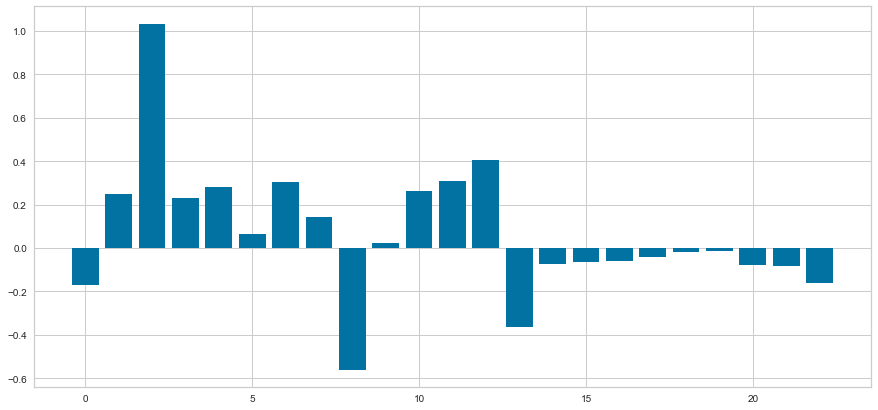

In [121]:
# look at coefficients only
# define the model
# logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
    print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. 
#The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts 
#class 0.

Feature:  LIMIT_BAL Score:      0.05735
Feature:  AGE Score:      0.07829
Feature:  PAY_1 Score:      0.02911
Feature:  PAY_2 Score:      0.16526
Feature:  PAY_3 Score:      0.00840
Feature:  PAY_4 Score:      0.01126
Feature:  PAY_5 Score:      0.00671
Feature:  PAY_6 Score:      0.01077
Feature:  BILL_AMT1 Score:      0.07238
Feature:  BILL_AMT2 Score:      0.05362
Feature:  BILL_AMT3 Score:      0.03964
Feature:  BILL_AMT4 Score:      0.04411
Feature:  BILL_AMT5 Score:      0.04379
Feature:  BILL_AMT6 Score:      0.04657
Feature:  PAY_AMT1 Score:      0.04783
Feature:  PAY_AMT2 Score:      0.04400
Feature:  PAY_AMT3 Score:      0.05732
Feature:  PAY_AMT4 Score:      0.04162
Feature:  PAY_AMT5 Score:      0.04389
Feature:  PAY_AMT6 Score:      0.04994
Feature:  SEX Score:      0.01359
Feature:  EDUCATION Score:      0.02150
Feature:  MARRIAGE Score:      0.01304


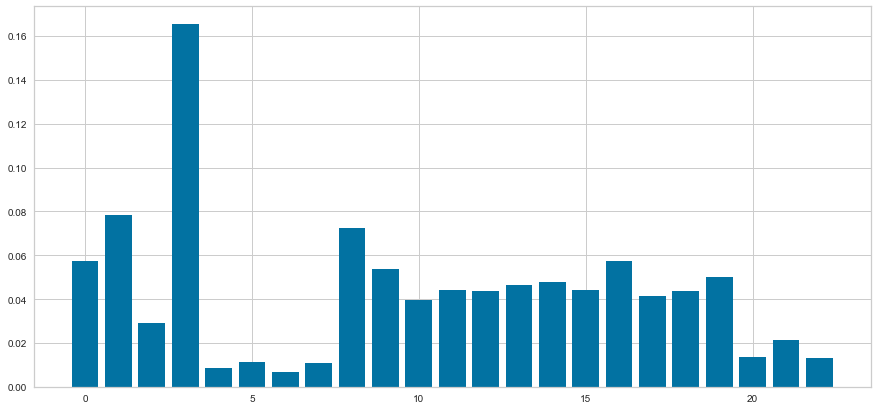

In [122]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# use CART classification feature importance
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# PAY_2 only shows importance to the score

Feature:  LIMIT_BAL Score:      0.06146
Feature:  AGE Score:      0.06584
Feature:  PAY_1 Score:      0.05328
Feature:  PAY_2 Score:      0.06903
Feature:  PAY_3 Score:      0.04676
Feature:  PAY_4 Score:      0.02178
Feature:  PAY_5 Score:      0.01541
Feature:  PAY_6 Score:      0.02070
Feature:  BILL_AMT1 Score:      0.06117
Feature:  BILL_AMT2 Score:      0.05414
Feature:  BILL_AMT3 Score:      0.04997
Feature:  BILL_AMT4 Score:      0.05335
Feature:  BILL_AMT5 Score:      0.05048
Feature:  BILL_AMT6 Score:      0.05138
Feature:  PAY_AMT1 Score:      0.04877
Feature:  PAY_AMT2 Score:      0.05083
Feature:  PAY_AMT3 Score:      0.04805
Feature:  PAY_AMT4 Score:      0.04232
Feature:  PAY_AMT5 Score:      0.04534
Feature:  PAY_AMT6 Score:      0.04493
Feature:  SEX Score:      0.01245
Feature:  EDUCATION Score:      0.01944
Feature:  MARRIAGE Score:      0.01312


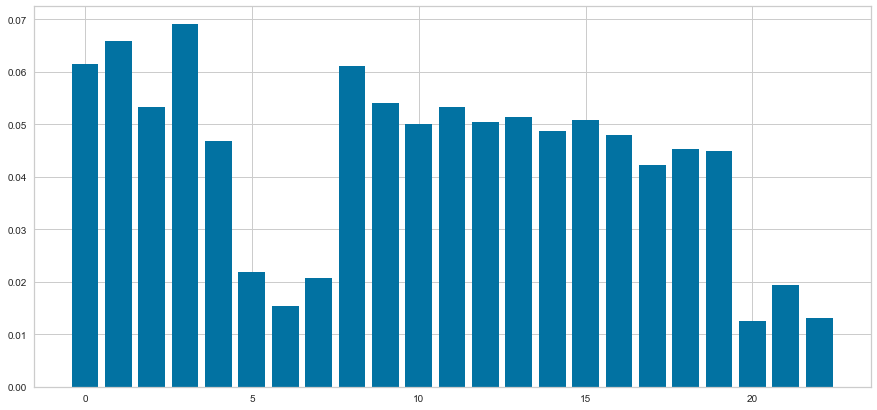

In [124]:
# use random forest feature importance
# This approach can also be used with the bagging and extra trees algorithms.
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [125]:
import xgboost

[13:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature:  LIMIT_BAL Score:      0.01498
Feature:  AGE Score:      0.01051
Feature:  PAY_1 Score:      0.05097
Feature:  PAY_2 Score:      0.62965
Feature:  PAY_3 Score:      0.01897
Feature:  PAY_4 Score:      0.03642
Feature:  PAY_5 Score:      0.01661
Feature:  PAY_6 Score:      0.02555
Feature:  BILL_AMT1 Score:      0.01618
Feature:  BILL_AMT2 Score:      0.01334
Feature:  BILL_AMT3 Score:      0.01268
Feature:  BILL_AMT4 Score:      0.01266
Feature:  BILL_AMT5 Score:      0.01282
Feature:  BILL_AMT6 Score:      0.01241
Feature:  PAY_AMT1 Score:      0.01191
Feature:  PAY_AMT2 Score:      0.01410
Feature:  PAY_AMT3 Score:      0.01660
Feature:  PAY_AMT4 Score:      0.01279
Feat

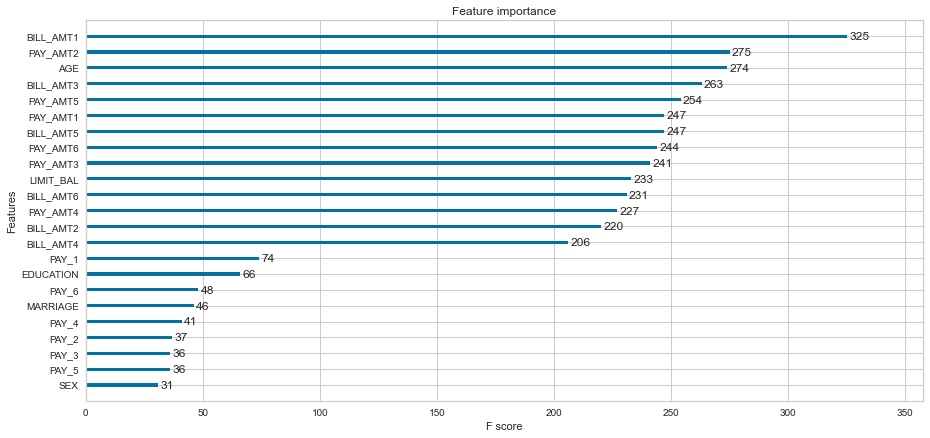

In [169]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# xgboost for feature importance on a classification problem

from xgboost import XGBClassifier
from xgboost import plot_importance

# define the model
model = XGBClassifier(random_state = 0)
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# plot feature importance
plot_importance(model)
plt.show()

In [127]:
from sklearn.feature_selection import f_classif

In [170]:


def f_score(X, y):
    """
    This function implements the anova f_value feature selection (existing method for classification in scikit-learn),
    where f_score = sum((ni/(c-1))*(mean_i - mean)^2)/((1/(n - c))*sum((ni-1)*std_i^2))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y : {numpy array},shape (n_samples,)
        input class labels

    Output
    ------
    F: {numpy array}, shape (n_features,)
        f-score for each feature
    """

    F, pval = f_classif(X, y)
    
    return F, pval


In [129]:
f_score(X, y)

(array([9.31819517e+02, 1.72874286e+00, 2.06772201e+03, 1.13983995e+03,
        9.17898380e+02, 6.69029435e+02, 5.96228643e+02, 4.43530908e+02,
        1.50112618e+01, 8.67999148e+00, 6.79968298e+00, 3.43250201e+00,
        1.96312421e+00, 2.93856540e+00, 8.95992607e+02, 6.90776427e+02,
        5.92721767e+02, 4.84263275e+02, 3.66256892e+02, 3.76624664e+02,
        4.79788543e+01, 2.35471118e+01, 1.77812714e+01]),
 array([1.44696567e-201, 1.88581577e-001, 0.00000000e+000, 2.84911917e-245,
        1.24780560e-198, 6.48332101e-146, 2.08073656e-130, 9.42396162e-098,
        1.07098536e-004, 3.21969761e-003, 9.12192061e-003, 6.39350023e-002,
        1.61189929e-001, 8.64978452e-002, 5.22890930e-194, 1.53951712e-150,
        1.16460753e-129, 1.75914339e-106, 3.72758466e-081, 2.19621370e-083,
        4.39524880e-012, 1.22503803e-006, 2.48536389e-005]))

In [176]:
def f_score2(X, y):
    """
    This function implements the anova f_value feature selection (existing method for classification in scikit-learn),
    where f_score = sum((ni/(c-1))*(mean_i - mean)^2)/((1/(n - c))*sum((ni-1)*std_i^2))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y : {numpy array},shape (n_samples,)
        input class labels

    Output
    ------
    F: {numpy array}, shape (n_features,)
        f-score for each feature
    """

    F, pval = f_classif(X, y)
    for i,v in enumerate(F):
        print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
    for i,v in enumerate(pval):
        print('Feature: ', list(X)[i], 'pval:      %.5f' % (v))
    
    return F, pval


In [177]:
f_score2(X, y)

Feature:  LIMIT_BAL Score:      931.81952
Feature:  AGE Score:      1.72874
Feature:  PAY_1 Score:      2067.72201
Feature:  PAY_2 Score:      1139.83995
Feature:  PAY_3 Score:      917.89838
Feature:  PAY_4 Score:      669.02943
Feature:  PAY_5 Score:      596.22864
Feature:  PAY_6 Score:      443.53091
Feature:  BILL_AMT1 Score:      15.01126
Feature:  BILL_AMT2 Score:      8.67999
Feature:  BILL_AMT3 Score:      6.79968
Feature:  BILL_AMT4 Score:      3.43250
Feature:  BILL_AMT5 Score:      1.96312
Feature:  BILL_AMT6 Score:      2.93857
Feature:  PAY_AMT1 Score:      895.99261
Feature:  PAY_AMT2 Score:      690.77643
Feature:  PAY_AMT3 Score:      592.72177
Feature:  PAY_AMT4 Score:      484.26328
Feature:  PAY_AMT5 Score:      366.25689
Feature:  PAY_AMT6 Score:      376.62466
Feature:  SEX Score:      47.97885
Feature:  EDUCATION Score:      23.54711
Feature:  MARRIAGE Score:      17.78127
Feature:  LIMIT_BAL pval:      0.00000
Feature:  AGE pval:      0.18858
Feature:  PAY_1 pva

(array([9.31819517e+02, 1.72874286e+00, 2.06772201e+03, 1.13983995e+03,
        9.17898380e+02, 6.69029435e+02, 5.96228643e+02, 4.43530908e+02,
        1.50112618e+01, 8.67999148e+00, 6.79968298e+00, 3.43250201e+00,
        1.96312421e+00, 2.93856540e+00, 8.95992607e+02, 6.90776427e+02,
        5.92721767e+02, 4.84263275e+02, 3.66256892e+02, 3.76624664e+02,
        4.79788543e+01, 2.35471118e+01, 1.77812714e+01]),
 array([1.44696567e-201, 1.88581577e-001, 0.00000000e+000, 2.84911917e-245,
        1.24780560e-198, 6.48332101e-146, 2.08073656e-130, 9.42396162e-098,
        1.07098536e-004, 3.21969761e-003, 9.12192061e-003, 6.39350023e-002,
        1.61189929e-001, 8.64978452e-002, 5.22890930e-194, 1.53951712e-150,
        1.16460753e-129, 1.75914339e-106, 3.72758466e-081, 2.19621370e-083,
        4.39524880e-012, 1.22503803e-006, 2.48536389e-005]))

In [132]:
#https://stackoverflow.com/questions/55466081/how-to-calculate-feature-importance-in-each-models-of-cross-validation-in-sklear

from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier


clf=RandomForestClassifier(n_estimators =10, random_state = 42, class_weight="balanced")
output = cross_validate(clf, X, y, cv=2, scoring = 'accuracy', return_estimator =True)
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances.head(20))


Features sorted by their score for estimator 0:
           importance
LIMIT_BAL    0.075854
BILL_AMT1    0.071660
AGE          0.069219
PAY_1        0.066952
PAY_AMT3     0.064675
BILL_AMT2    0.063599
PAY_AMT1     0.061141
PAY_AMT2     0.060831
BILL_AMT5    0.054599
BILL_AMT3    0.053440
PAY_AMT4     0.052444
BILL_AMT6    0.052101
BILL_AMT4    0.051749
PAY_AMT6     0.051097
PAY_AMT5     0.045136
PAY_2        0.024946
EDUCATION    0.022982
MARRIAGE     0.013584
SEX          0.012782
PAY_6        0.012465
Features sorted by their score for estimator 1:
           importance
PAY_3        0.145003
PAY_1        0.132776
PAY_2        0.101071
PAY_5        0.056616
PAY_4        0.047885
PAY_6        0.046829
LIMIT_BAL    0.040583
BILL_AMT2    0.037253
BILL_AMT1    0.036059
BILL_AMT3    0.036029
PAY_AMT2     0.032603
BILL_AMT6    0.032473
BILL_AMT4    0.032172
BILL_AMT5    0.032066
AGE          0.030090
PAY_AMT3     0.029145
PAY_AMT1     0.028270
PAY_AMT6     0.027664
PAY_AMT4     0.025982
PA

# Principal Component Analysis

In [133]:
df_quant2 = df.filter(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)

In [134]:
features = df_quant2

In [135]:
df_quant2.shape

(30000, 20)

### PCA: Some of the variables are highly correlated to a great extent and there are still a great many features. Conduct PCA analysis for dimensionalty reduction and to address multicollinearity.

In [136]:
#PCA
# https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
from sklearn.decomposition import PCA


In [137]:
pca=PCA(n_components=0.99, whiten=True)

In [138]:
features_pca = pca.fit_transform(features)

In [139]:
print("original number of features:", features.shape[1])

original number of features: 20


In [140]:
print("reduced number of features:", features_pca.shape[1])

reduced number of features: 8


In [141]:
model = PCA(n_components=8, whiten=True).fit(df_quant)
X_pc = model.transform(df_quant)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
impPca = pd.DataFrame(sorted(dic.items()))


In [142]:
print(impPca)

     0          1
0  PC1  LIMIT_BAL
1  PC2  LIMIT_BAL
2  PC3  BILL_AMT1
3  PC4   PAY_AMT2
4  PC5   PAY_AMT4
5  PC6   PAY_AMT3
6  PC7   PAY_AMT1
7  PC8   PAY_AMT5


In [143]:
print('model: ', type(model))
print('X_pc: ', type(X_pc))
print('n_pcs: ', type(n_pcs))
print('most_important: ', type(most_important))
print('most_important_names: ', type(most_important_names))
print('dic: ', type(dic))
print('dfpca: ', type(impPca))

model:  <class 'sklearn.decomposition.pca.PCA'>
X_pc:  <class 'numpy.ndarray'>
n_pcs:  <class 'int'>
most_important:  <class 'list'>
most_important_names:  <class 'list'>
dic:  <class 'dict'>
dfpca:  <class 'pandas.core.frame.DataFrame'>


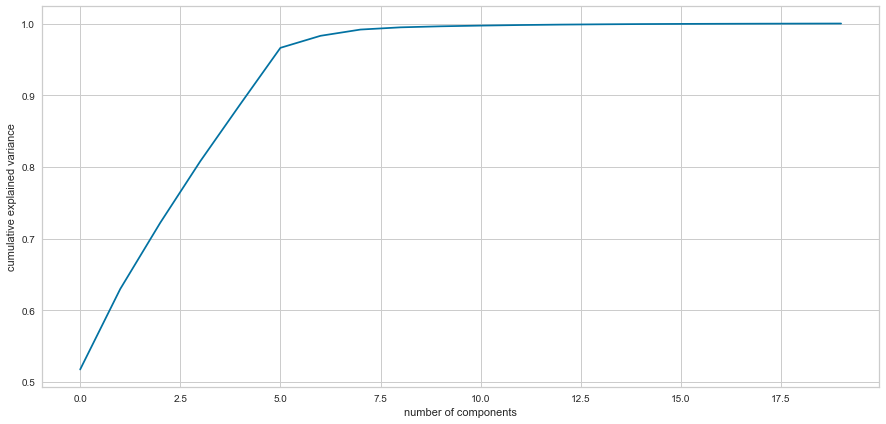

In [144]:
pca = PCA().fit(df_quant2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [145]:
# create new dataframe with PCA features
pcaDf = pd.DataFrame(data = features_pca, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])


In [146]:
pcaDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.957833,0.937311,1.089232,-3.070175,-1.616449,-0.714438,1.412181,0.851787
1,0.140456,0.781096,1.595321,0.000953,-0.933724,-2.166769,0.354654,1.852528
2,0.975396,0.018375,-0.006510,0.065376,-0.051777,-0.004641,0.500938,1.655141
3,-0.147522,1.543874,-1.033714,-1.732933,2.264226,0.395811,1.405861,0.736916
4,-0.029195,-0.055276,0.443091,3.284571,-0.871001,2.759460,0.446885,2.491130


In [147]:
pcaDf.shape

(30000, 8)

In [148]:
# add categorical variables back to df

pcaDf['SEX'] = df['SEX'] 
pcaDf['EDUCATION'] = df['EDUCATION']
pcaDf['MARRIAGE'] = df['MARRIAGE']
pcaDf['default'] = df['default']

In [149]:
for c in pcaDf.columns:
    miss = pcaDf[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

In [150]:
pcaDf.shape

(30000, 12)

In [151]:
is_NaN = pcaDf.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = pcaDf[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, SEX, EDUCATION, MARRIAGE, default]
Index: []


In [152]:
# export the revised df to a csv file
pcaDf.to_csv('pcaDefault.csv', index = False)

# Feature selection with PCA variables

In [178]:
# convert categorical data to numbers

#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[cat_features]

# One Hot Encoding 
dfDumm = pd.get_dummies(df_cat)

In [179]:
# here we will combine the numerical features and the dummie features together
dfNum = pcaDf.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
#Xdumm = pd.concat([dfNum, dfDumm], axis=1)
#X = pd.concat([df_quant2, dfDumm], axis=1)
X = pd.concat([dfNum, dfDumm], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  df['default']
#yRF = df['fraud_reported']

Feature:  PC1 Score:      -0.47074
Feature:  PC2 Score:      0.16897
Feature:  PC3 Score:      -0.03510
Feature:  PC4 Score:      -0.02972
Feature:  PC5 Score:      -0.02317
Feature:  PC6 Score:      0.03034
Feature:  PC7 Score:      0.73030
Feature:  PC8 Score:      0.35426
Feature:  SEX Score:      -0.09075
Feature:  EDUCATION Score:      -0.07530
Feature:  MARRIAGE Score:      -0.21595


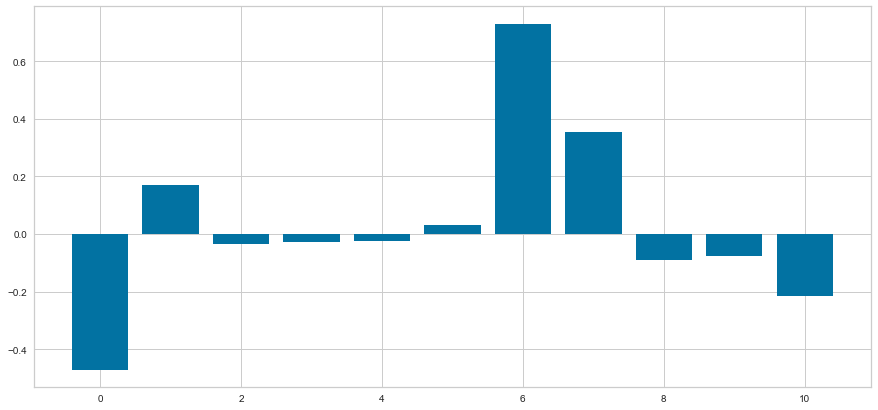

In [180]:
# feature selection
#https://medium.com/swlh/feature-importance-hows-and-why-s-3678ede1e58f#:~:text=Features%20with%20a%20p_value%20of,used%20in%20the%20predictive%20model.&text=This%20is%20one%20of%20the,lines%20of%20code%20to%20execute.
# look at coefficients only
# define the model
# logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
    print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. 
#The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts 
#class 0.

Feature:  PC1 Score:      0.11685
Feature:  PC2 Score:      0.09448
Feature:  PC3 Score:      0.09874
Feature:  PC4 Score:      0.09268
Feature:  PC5 Score:      0.08766
Feature:  PC6 Score:      0.08143
Feature:  PC7 Score:      0.20975
Feature:  PC8 Score:      0.16153
Feature:  SEX Score:      0.01375
Feature:  EDUCATION Score:      0.02467
Feature:  MARRIAGE Score:      0.01846


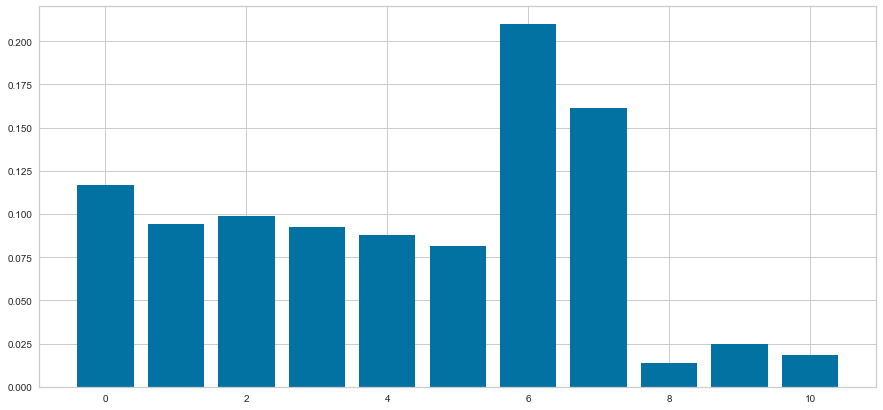

In [181]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# use CART classification feature importance
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature:  PC1 Score:      0.12942
Feature:  PC2 Score:      0.09947
Feature:  PC3 Score:      0.10007
Feature:  PC4 Score:      0.09618
Feature:  PC5 Score:      0.09475
Feature:  PC6 Score:      0.10055
Feature:  PC7 Score:      0.18120
Feature:  PC8 Score:      0.14231
Feature:  SEX Score:      0.01392
Feature:  EDUCATION Score:      0.02395
Feature:  MARRIAGE Score:      0.01818


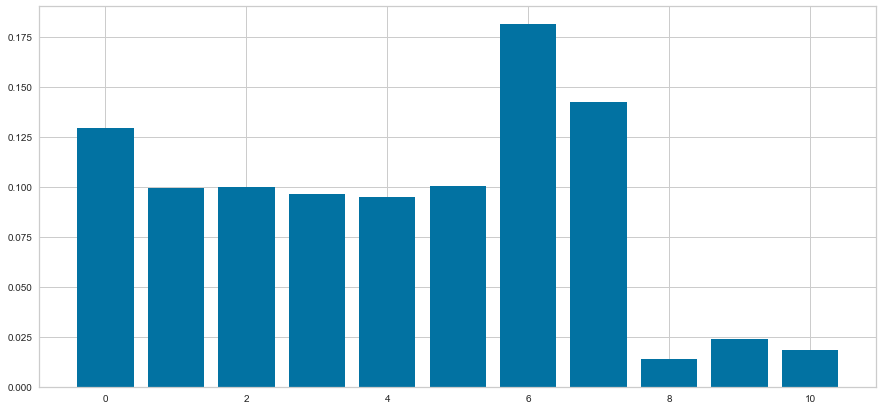

In [182]:
# use random forest feature importance
# This approach can also be used with the bagging and extra trees algorithms.
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [186]:
#https://stackoverflow.com/questions/55466081/how-to-calculate-feature-importance-in-each-models-of-cross-validation-in-sklear

from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier


clf=RandomForestClassifier(n_estimators =10, random_state = 42, class_weight="balanced")
output = cross_validate(clf, X, y, cv=2, scoring = 'accuracy', return_estimator =True)
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances.head(20))

Features sorted by their score for estimator 0:
           importance
PC1          0.139812
PC7          0.138783
PC8          0.123944
PC2          0.113617
PC6          0.108763
PC5          0.107764
PC4          0.104443
PC3          0.104125
EDUCATION    0.029824
MARRIAGE     0.016111
SEX          0.012815
Features sorted by their score for estimator 1:
           importance
PC7          0.328484
PC8          0.162464
PC1          0.094432
PC3          0.084234
PC2          0.080617
PC4          0.078026
PC5          0.070517
PC6          0.066324
EDUCATION    0.016340
MARRIAGE     0.010603
SEX          0.007959


[17:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature:  PC1 Score:      0.10652
Feature:  PC2 Score:      0.07091
Feature:  PC3 Score:      0.06430
Feature:  PC4 Score:      0.06784
Feature:  PC5 Score:      0.06093
Feature:  PC6 Score:      0.06270
Feature:  PC7 Score:      0.22956
Feature:  PC8 Score:      0.15402
Feature:  SEX Score:      0.05166
Feature:  EDUCATION Score:      0.06600
Feature:  MARRIAGE Score:      0.06557


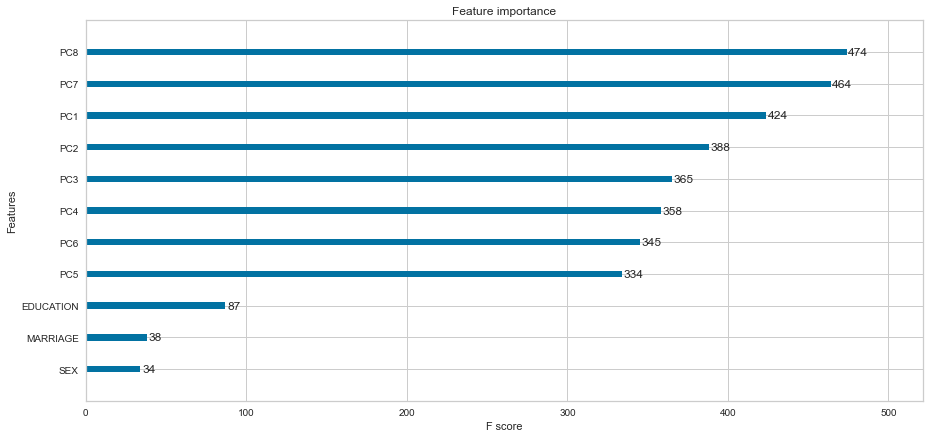

In [183]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# xgboost for feature importance on a classification problem

from xgboost import XGBClassifier
from xgboost import plot_importance

# define the model
model = XGBClassifier(random_state = 0)
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# plot feature importance
plot_importance(model)
plt.show()

In [184]:
def f_score(X, y):
    """
    This function implements the anova f_value feature selection (existing method for classification in scikit-learn),
    where f_score = sum((ni/(c-1))*(mean_i - mean)^2)/((1/(n - c))*sum((ni-1)*std_i^2))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y : {numpy array},shape (n_samples,)
        input class labels

    Output
    ------
    F: {numpy array}, shape (n_features,)
        f-score for each feature
    """

    F, pval = f_classif(X, y)
    for i,v in enumerate(F):
        print('Feature: ', list(X)[i], 'Score:      %.5f' % (v))
    for i,v in enumerate(pval):
        print('Feature: ', list(X)[i], 'pval:      %.5f' % (v))
    
    return F, pval

In [185]:
f_score(X, y)

Feature:  PC1 Score:      994.34112
Feature:  PC2 Score:      164.84839
Feature:  PC3 Score:      6.66241
Feature:  PC4 Score:      8.65081
Feature:  PC5 Score:      2.05455
Feature:  PC6 Score:      7.18928
Feature:  PC7 Score:      1937.21960
Feature:  PC8 Score:      383.20005
Feature:  SEX Score:      47.97885
Feature:  EDUCATION Score:      23.54711
Feature:  MARRIAGE Score:      17.78127
Feature:  PC1 pval:      0.00000
Feature:  PC2 pval:      0.00000
Feature:  PC3 pval:      0.00985
Feature:  PC4 pval:      0.00327
Feature:  PC5 pval:      0.15176
Feature:  PC6 pval:      0.00734
Feature:  PC7 pval:      0.00000
Feature:  PC8 pval:      0.00000
Feature:  SEX pval:      0.00000
Feature:  EDUCATION pval:      0.00000
Feature:  MARRIAGE pval:      0.00002


(array([ 994.34111661,  164.84839014,    6.662406  ,    8.65081071,
           2.05455353,    7.18928131, 1937.21959789,  383.20004964,
          47.97885435,   23.54711184,   17.78127139]),
 array([9.83413645e-215, 1.24054569e-037, 9.85149004e-003, 3.27165590e-003,
        1.51762153e-001, 7.33804639e-003, 0.00000000e+000, 8.47252139e-085,
        4.39524880e-012, 1.22503803e-006, 2.48536389e-005]))